# GST/RGST data analysis

This notebook walks through the reconstruction of the gate operations for both the randomized and unrandomized experiments. The general outline is:
  * Load the GST files and do the GST reconstruction
  * Save this data in .pkl files and use this data to generate the $N_\sigma$ metric along with others
      * At the same time, calculate the Pauli projections of the data
      * Save all the analysis data in .npz files for future analysis
  * Calculate the diamond-norm distance
  * Plot the reconstructed Pauli maps (along with the confidence intervals)
  * Generate error bars for the infidelities and the diamond-norms
  
Along the way, you'll have the option to calculate everything or use existing, precalculated data. The GST reconstructions are time and resource-intensive to calculate. The existing .pkl and .npz files have all the data you need to reproduce the plots and analysis.

In [332]:
# lots of warnings due to new Julia version
using PyPlot, StatsBase, Glob, Formatting, QuantumInfo, SchattenNorms, NPZ, Distributions

using PyCall
@pyimport seaborn as sns

rcParams = PyPlot.PyDict(PyPlot.matplotlib["rcParams"])
rcParams["figure.dpi"] = 300

300

## Coherence limit

Superoperator for evolution of a memory with the gate duration and coherence times extracted from experiments

In [354]:
T=expm(0.05/10.0*dissipator([0 1; 0 0])+1/2*0.05*(1/(13.0)-1/(2*10.0))*dissipator([1 0; 0 -1]));

In [355]:
1-avgfidelity(eye(4),T)

0.0021108424245417368

In [356]:
ddist(eye(4),T)

----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 218, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 34, constraints m = 193
Cones:	primal zero / dual free vars: 85
	sd vars: 108, sd blks: 3
Setup time: 1.31e-04s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 6.64e-02  1.16e+01  1.31e-01 -3.13e-02  1.20e-01  2.56e-17  1.63e-04 
    40| 5.00e-12  9.58e-10  1.00e-13  4.99e-03  4.99e-03  2.39e-19  4.08e-03 
------------------------------------------------------

0.009975041608550875

## Run GST analysis and format data (optional!)

Here, we pass the datafiles with single-shot state asignments to pygsti where it does a reconstruction of the $\rho, E, G_i, G_x, G_y$ operators. We pickle these results so we don't have to repeat the expensive pygsti reconstructions and perform the Pauli projects. Note these data files already exist in the `../data/` folder.

In [ ]:
# do GST analysis
@sync begin
    for i in 1:7
        # replace with:
        # @async begin
        # on a machine with many cores and lots of RAM
        @sync begin
            pipeline(`../scripts/gst-1q-with-ci.py --maxlength 1024 --input ../data/gst_$i.gst --verbosity 1`,
                     stdout=DevNull,
                     stderr=DevNull) |> run
            println("gst_$i.gst : GST done!")
            pipeline(`../scripts/pkl2npz-1q.py --input ../data/gst_$i.pkl`,
                     stdout=DevNull,
                     stderr=DevNull) |> run
            println("gst_$i.gst :  Pauli projection analysis done!")
        end
    end
end

In [ ]:
@sync begin
    for i in 1:7
        # replace with:
        # @async begin
        # on a machine with many cores and lots of RAM
        @sync begin
            pipeline(`../scripts/gst-1q-with-ci.py --maxlength 1024 --input ../data/rgst_$i.gst --verbosity 1`,
                     stdout=DevNull,
                     stderr=DevNull) |> run
            println("rgst_$i.gst : GST done!")
            pipeline(`../scripts/pkl2npz-1q.py --input ../data/rgst_$i.pkl`,
                     stdout=DevNull,
                     stderr=DevNull) |> run
            println("rgst_$i.gst :  Pauli projection analysis done!")
        end
    end
end

## Load data

In [2]:
gst_nsig = reduce(hcat,[npzread("../data/gst_$i.npz")["paulilogL"][end,[4,7]] for i in 1:7]);

In [3]:
rgst_nsig = reduce(hcat,[npzread("../data/rgst_$i.npz")["paulilogL"][end,[4,7]] for i in 1:7]);

In [4]:
gst_cis_max = reduce(hcat,[[maximum(real.(npzread("../data/gst_$j.npz")["cis"][i,:,:])) for i in 1:3] for j in 1:7]);
rgst_cis_max = reduce(hcat,[[maximum(real.(npzread("../data/rgst_$j.npz")["cis"][i,:,:])) for i in 1:3] for j in 1:7]);

In [5]:
gst_cis = reduce(hcat,[[real.(npzread("../data/gst_$j.npz")["cis"][i,:,:]) for i in 1:3] for j in 1:7]);
rgst_cis = reduce(hcat,[[real.(npzread("../data/rgst_$j.npz")["cis"][i,:,:]) for i in 1:3] for j in 1:7]);

The hessians are not symmetric, but only due to finite precision. We need to enforce that to sample from the corresponding normal distribution with variance set by the hessian.

In [6]:
sym_part(M) = (M+M')/2

sym_part (generic function with 1 method)

In [7]:
gst_gate_hessian = [[real.(npzread("../data/gst_$j.npz")["hessian"][i,:,:])|>sym_part for i in 1:3] for j in 1:7];
rgst_gate_hessian = [[real.(npzread("../data/rgst_$j.npz")["hessian"][i,:,:])|>sym_part for i in 1:3] for j in 1:7];

## Plotting

### Badness of fit 

extrema of model violation without randomization

In [8]:
extrema(gst_nsig'[1:7,1])

(43.511638462178944, 76.16159801740193)

extrema of model violation without randomization and with restriction to Pauli errors

In [9]:
extrema(gst_nsig'[1:7,2])

(1754.9877284989348, 1987.6503593787427)

extrema of model violation *with* randomization

In [10]:
extrema(rgst_nsig'[1:7,1])

(0.29457656951911027, 1.9145348704116694)

extrema of model violation *with* randomization and restriction to Pauli errors

In [11]:
extrema(rgst_nsig'[1:7,2])

(0.8726898917541959, 2.6884828947793165)

Visually:

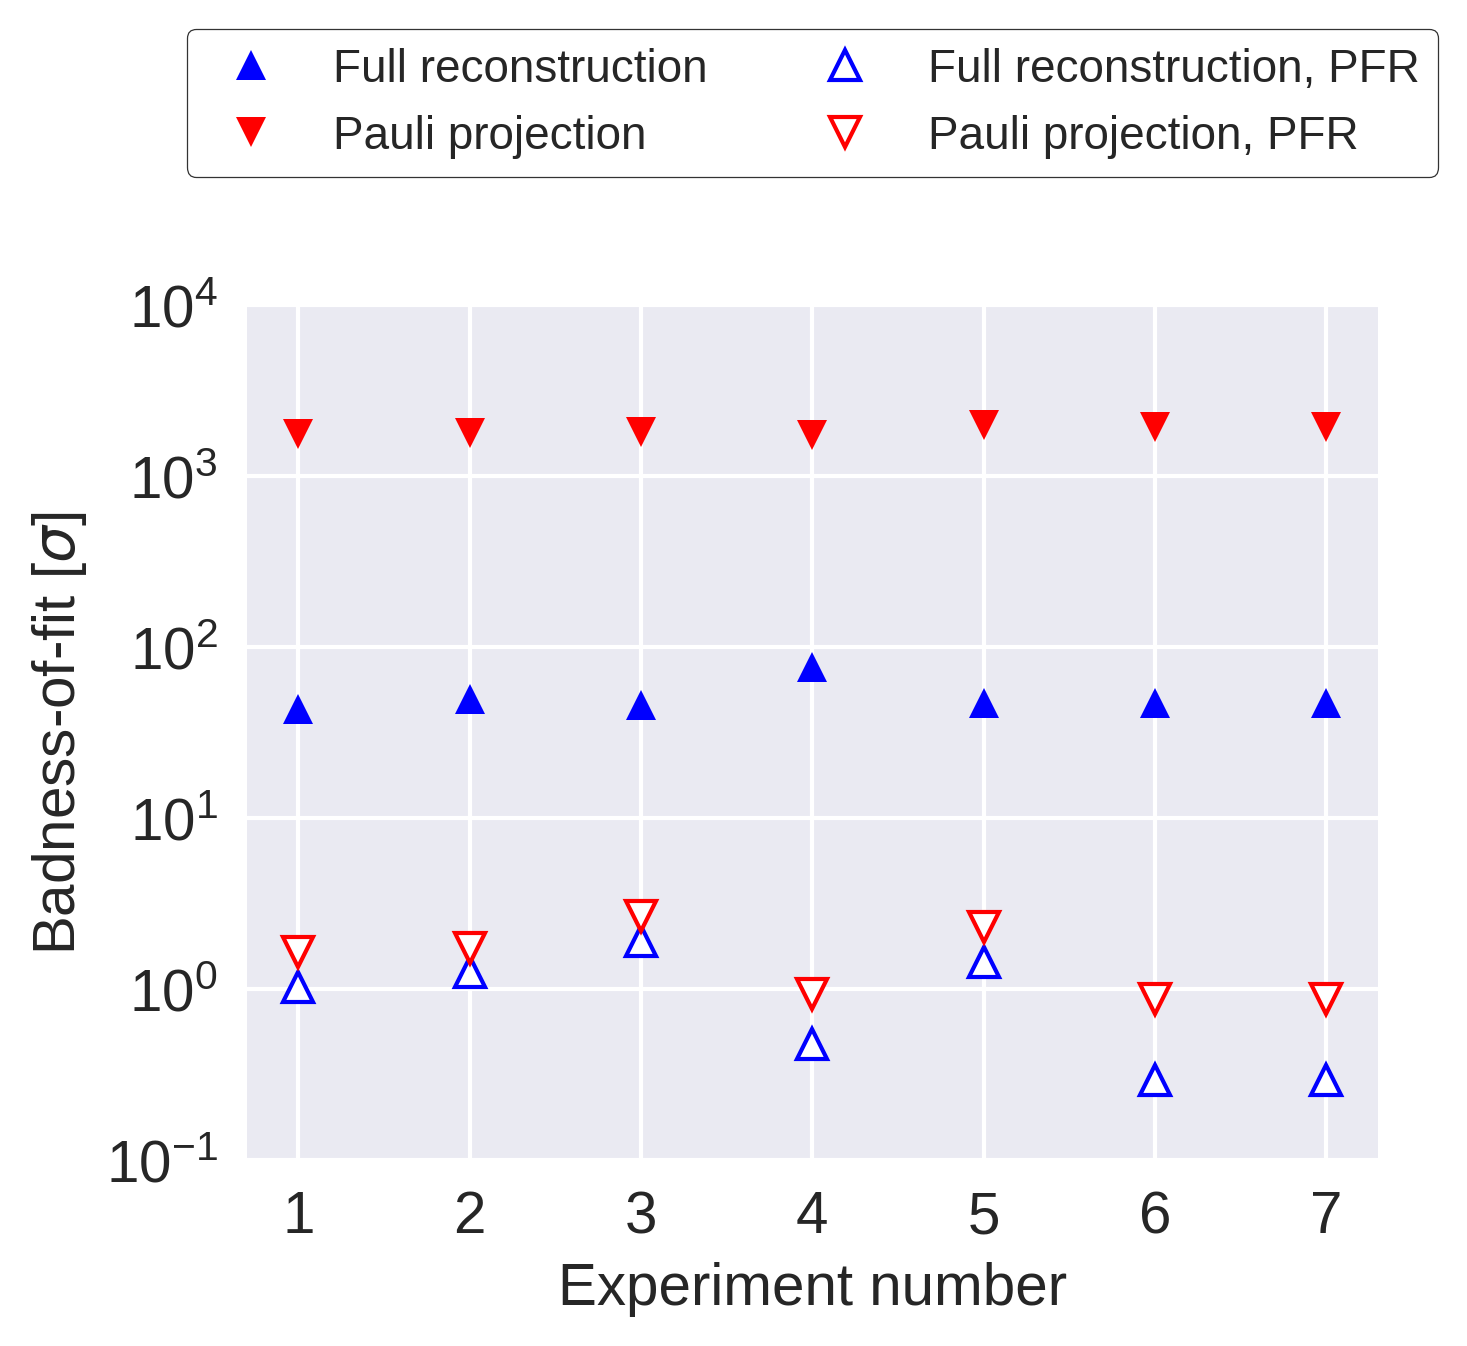

In [333]:
font_size = 14

figure(figsize=(5,5))

semilogy(1:7,gst_nsig'[1:7,1],"b^")
semilogy(1:7,gst_nsig'[1:7,2],"rv")
semilogy(1:7,rgst_nsig'[1:7,1],"b^",mfc="white",mew=1)
semilogy(1:7,rgst_nsig'[1:7,2],"rv",mfc="white",mew=1)
ylim([.1,1E4])
xticks([])
legend(["Full reconstruction",
        "Pauli projection",
        "Full reconstruction, PFR", 
        "Pauli projection, PFR"],
    frameon=true,
    facecolor="white",
    edgecolor="black",
    fontsize=11,
    ncol=2,
    bbox_to_anchor=(0.5,1.35),
    loc="upper center"
)

ylabel(L"Badness-of-fit [$\sigma$]", fontsize=font_size)
xlabel("Experiment number", fontsize=font_size)

xticks(1:7,fontsize=font_size)
yticks(fontsize=font_size)

tight_layout()
savefig("../figs/GST_reconstruction.pdf", dpi=600)

### Average gate fidelity and diamond distance

In [15]:
target = Vector{Matrix{Complex128}}(3);
gst_gates = Matrix{Matrix{Complex128}}(3,7);
rgst_gates = Matrix{Matrix{Complex128}}(3,7);

In [16]:
for j in 1:7
    gst_result = npzread("../data/gst_$j.npz")
    rgst_result = npzread("../data/rgst_$j.npz")
    if j == 1
        for i in 1:3
            target[i] = gst_result["target"][i,:,:] |> pauliliou2liou
        end
    end
    for i in 1:3
        gst_gates[i,j]  = gst_result["final"][i,:,:] |> pauliliou2liou
        rgst_gates[i,j] = rgst_result["final"][i,:,:] |> pauliliou2liou
    end
end

In [17]:
gst_avgfid  = [avgfidelity(gst_gates[i,j],target[i]) for i in 1:3, j in 1:7];
gst_avgfid_ = reduce(hcat,[real.(npzread("../data/gst_$j.npz")["avgfid"]) for j in 1:7]);
gst_avgfid_err = reduce(hcat,[real.(npzread("../data/gst_$j.npz")["avgfiderr"]) for j in 1:7]);
rgst_avgfid = [avgfidelity(rgst_gates[i,j],target[i]) for i in 1:3, j in 1:7];
rgst_avgfid_ = reduce(hcat,[real.(npzread("../data/rgst_$j.npz")["avgfid"]) for j in 1:7]);
rgst_avgfid_err = reduce(hcat,[real.(npzread("../data/rgst_$j.npz")["avgfiderr"]) for j in 1:7]);

In [18]:
gst_ddist = Matrix{Float64}(3,7)
for j in 1:7, i in 1:3
    gst_ddist[i,j] = ddist(gst_gates[i,j],target[i])/2
end

----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 218, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 34, constraints m = 193
Cones:	primal zero / dual free vars: 85
	sd vars: 108, sd blks: 3
Setup time: 1.12e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 5.47e-01  6.52e+00  4.99e-01 -2.88e-01  7.09e-01  2.27e-16  8.89e-02 
   100| 3.29e-07  8.40e-06  2.07e-07  5.02e-02  5.02e-02  4.38e-18  1.16e-01 
------------------------------------------------------

In [19]:
rgst_ddist = Matrix{Float64}(3,7)
for j in 1:7, i in 1:3
    rgst_ddist[i,j] = ddist(rgst_gates[i,j],target[i])/2
end

----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 218, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 34, constraints m = 193
Cones:	primal zero / dual free vars: 85
	sd vars: 108, sd blks: 3
Setup time: 8.77e-05s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.54e-01  7.07e+00  1.31e-01 -6.43e-02  8.65e-02  4.93e-17  1.88e-04 
    80| 4.56e-08  4.20e-06  1.88e-08  1.20e-02  1.20e-02  3.71e-18  1.13e-02 
------------------------------------------------------

In [20]:
maximum(abs.(gst_avgfid-gst_avgfid_)),maximum(abs.(rgst_avgfid-rgst_avgfid_))

(3.3306690738754696e-16, 3.3306690738754696e-16)

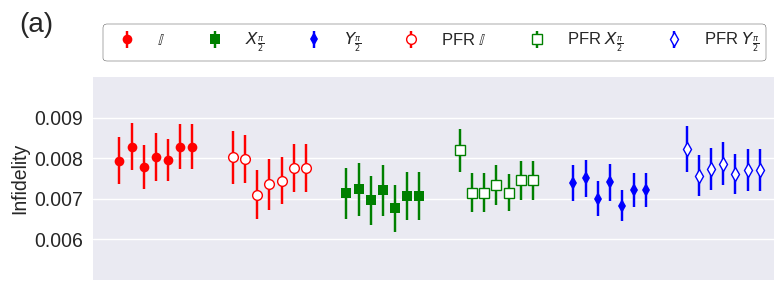

In [268]:
font_size = 14

figure(figsize=(8,3))

color = ["r","g","b"]
labels = [L"$\mathbb{I}$",L"$X_\frac{\pi}{2}$",L"$Y_\frac{\pi}{2}$"]
marker = ["o","s","d"]
for i=1:3
    errorbar(
        x=2*(i-1)+1.5+0.75/7*collect(1:7)-0.75/2,
        y=1-gst_avgfid'[1:7,i]|>vec,
        yerr=gst_avgfid_err[i,:],
        fmt="$(color[i])$(marker[i])",
        label=labels[i]
    )
end
for i=1:3
    errorbar(
        x=2*(i-1)+2.5+0.75/7*collect(1:7)-0.75/2,
        y=1-rgst_avgfid'[1:7,i]|>vec,
        yerr=rgst_avgfid_err[i,:],
        fmt="$(color[i])$(marker[i])",
        mfc="white",
        mew=1,
        label=latexstring("PFR ",labels[i])
    )
end
ylim([.005,.01])
yticks([0.006,0.007,0.008,0.009])

xlim([1,7])
xticks([])
#xlabel("Experiment Number", fontsize=font_size)
ylabel("Infidelity", fontsize=font_size)
#title("Infidelity wrt ideal gate target", fontsize=font_size)
legend(bbox_to_anchor=(1, 1.3),
       fontsize=10.75,
       frameon=true,
       edgecolor="black",
       facecolor="white", 
       ncol=6,
       fontsize=12)

xticks(fontsize=font_size)
yticks(fontsize=font_size)

annotate("(a)",
            xy=(0.025,.96), xycoords="figure fraction",
            horizontalalignment="left", verticalalignment="top",
            fontsize=20)

tight_layout()
savefig("../figs/infidelity.pdf", dpi=600)

In [22]:
function sample_perturbed_gate!(gst_or_rgst, experiment, gate_idx, N_samples)
    gst_result = npzread("../data/$(gst_or_rgst)_$experiment.npz")
    samples = rand(MvNormal(vec(real.(gst_result["final"][1,:,:])), gst_gate_hessian[experiment][gate_idx]),N_samples)
    reshape(samples,(4,4,N_samples))
end

sample_perturbed_gate! (generic function with 1 method)

In [23]:
gst_ddist_err =
[
    begin
        N_samples = 200;
        t = sample_perturbed_gate!("gst",j,i,N_samples);
        samples = [ddist(t[:,:,k]|>pauliliou2liou,target[i])/2 for k in 1:N_samples]
        ci = quantile(samples,[0.025,0.975]);
        (ci[2]-ci[1])/2
    end
    for j in 1:7, i in 1:3
];

----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 218, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 34, constraints m = 193
Cones:	primal zero / dual free vars: 85
	sd vars: 108, sd blks: 3
Setup time: 6.10e-05s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 5.48e-01  6.52e+00  4.98e-01 -2.88e-01  7.04e-01  2.27e-16  1.64e-04 
   100| 1.06e-06  2.13e-05  1.14e-07  5.03e-02  5.03e-02  2.95e-17  1.52e-02 
   120| 4.85e-07  9.81e-06  5.72e-07  5.03e-02  5.03e-

In [24]:
rgst_ddist_err =
[
    begin
        N_samples = 200;
        t = sample_perturbed_gate!("rgst",j,i,N_samples);
        samples = [ddist(t[:,:,k]|>pauliliou2liou, target[i])/2 for k in 1:N_samples]
        ci = quantile(samples,[0.025,0.975]);
        (ci[2]-ci[1])/2
    end
    for j in 1:7, i in 1:3
];

----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 218, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 34, constraints m = 193
Cones:	primal zero / dual free vars: 85
	sd vars: 108, sd blks: 3
Setup time: 9.59e-05s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.60e-01  7.11e+00  1.36e-01 -6.69e-02  9.11e-02  5.12e-17  2.61e-04 
    80| 2.76e-08  2.94e-06  1.23e-08  1.25e-02  1.25e-02  2.36e-17  1.24e-02 
------------------------------------------------------

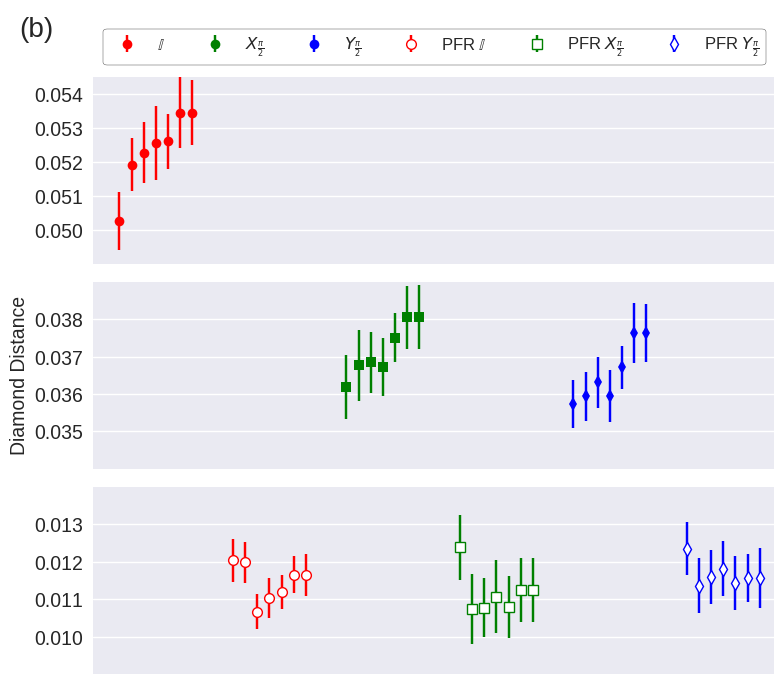

In [264]:
font_size = 14
marker = ["o","s","d"]
color = ["r","g","b"]
labels = [L"$\mathbb{I}$",L"$X_\frac{\pi}{2}$",L"$Y_\frac{\pi}{2}$"]

subplots(3,1,figsize=(8,7),sharex=true)

subplot(3,1,3)
for i=1:3
    errorbar(
        x=2*(i-1)+2.5+0.75/7*collect(1:7)-0.75/2,
        y=rgst_ddist'[1:7,i]|>vec,
        yerr=rgst_ddist_err[:,i],
        fmt="$(color[i])$(marker[i])",
        mfc="white",
        mew=1,
        label=labels[i]
    )
end
ylim([.009,.014])
yticks([0.01,0.011,0.012,0.013])

xlim([1,7])
xticks([])

xticks(fontsize=font_size)
yticks(fontsize=font_size)

subplot(3,1,2)
for i=1:3
    errorbar(
        x=2*(i-1)+1.5+0.75/7*collect(1:7)-0.75/2,
        y=gst_ddist'[1:7,i]|>vec,
        yerr=gst_ddist_err[:,i],
        fmt="$(color[i])$(marker[i])",
        label=labels[i]
    )
end
ylim([.034,.039])
yticks([0.035,0.036,0.037,0.038])
#legend(bbox_to_anchor=(1.25, 1),fontsize=12,frameon=true,edgecolor="black",facecolor="white")

xlim([1,7])
xticks([])
ylabel("Diamond Distance", fontsize=font_size)

yticks(fontsize=font_size)

#savefig("infidelity.png", dpi=600)

subplot(3,1,1)
color = ["r","g","b"]
labels = [L"$\mathbb{I}$",L"$X_\frac{\pi}{2}$",L"$Y_\frac{\pi}{2}$"]
for i=1:3
    errorbar(
        x=2*(i-1)+1.5+0.75/7*collect(1:7)-0.75/2,
        y=gst_ddist'[1:7,i]|>vec,
        yerr=gst_ddist_err[:,i],
        fmt="$(color[i])o",
        label=labels[i]
    )
end
for i=1:3
    errorbar(
        x=2*(i-1)+2.5+0.75/7*collect(1:7)-0.75/2,
        y=rgst_ddist'[1:7,i]|>vec,
        yerr=rgst_ddist_err[:,i],
        fmt="$(color[i])$(marker[i])",
        mfc="white",
        mew=1,
        label=latexstring("PFR ",labels[i])
    )
end
legend(bbox_to_anchor=(1, 1.3),
       fontsize=10.75,
       frameon=true,
       edgecolor="black",
       facecolor="white", 
       ncol=6,
       fontsize=12)
ylim([.0490,.0545])
yticks([0.050,0.051,0.052,0.053,0.054])

xlim([1,7])
xticks([])

yticks(fontsize=font_size)

annotate("(b)",
            xy=(0.025,.975), xycoords="figure fraction",
            horizontalalignment="left", verticalalignment="top",
            fontsize=20)

tight_layout()
savefig("../figs/diamond_dist.pdf", dpi=600)

## Reconstructed Gates

In [26]:
gate = [L"$\mathbb{I}$",L"$X\left(\frac{\pi}{2}\right)$",L"$Y\left(\frac{\pi}{2}\right)$"]

3-element Array{LaTeXStrings.LaTeXString,1}:
 L"$\mathbb{I}$"                 
 L"$X\left(\frac{\pi}{2}\right)$"
 L"$Y\left(\frac{\pi}{2}\right)$"

In [27]:
emax = round(1e3*max(maximum(gst_cis_max),maximum(rgst_cis_max)))/1e3

0.003

In [28]:
mplt = pyimport("mpl_toolkits.axes_grid1")# import make_axes_locatable

PyObject <module 'mpl_toolkits.axes_grid1' from '/opt/conda/lib/python3.6/site-packages/mpl_toolkits/axes_grid1/__init__.py'>

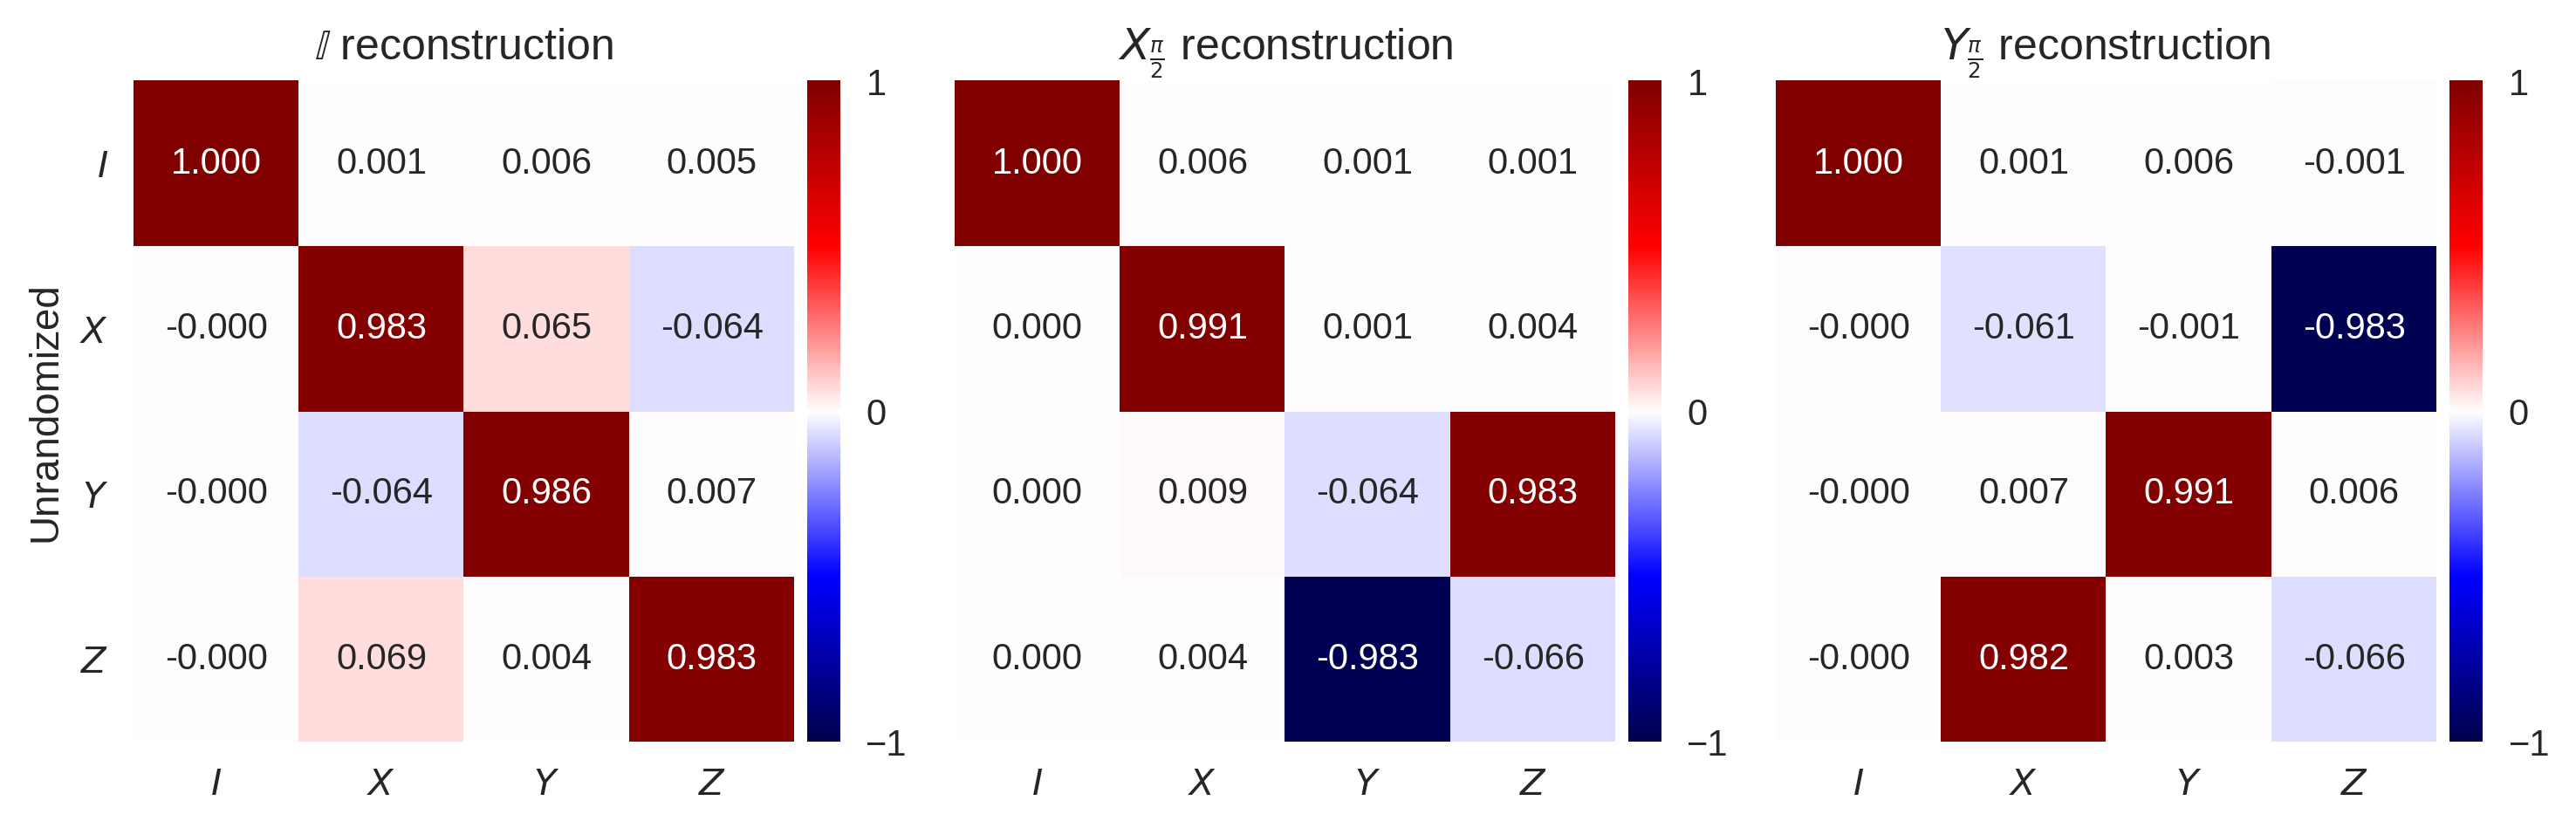

In [334]:
expr = 1
f,(ax1,ax2,ax3) = subplots(1,3, 
                           gridspec_kw=Dict("width_ratios"=>[1,1,1]),
                           figsize=(10,10))
ax = [ax1,ax2,ax3]
labels = [L"$\mathbb{I}$",L"$X_\frac{\pi}{2}$",L"$Y_\frac{\pi}{2}$"]

for g in 1:3
    divider = mplt[:make_axes_locatable](ax[g])
    cax = divider[:append_axes]("right", size="5%", pad=0.05)
    sca(ax[g])
    sns.heatmap(
        real.(gst_gates[g,expr]|>liou2pauliliou),
        annot=true,
        square=true,
        fmt="3.3f",
        vmin=-1,
        vmax=1,
        cbar=true,
        ax=ax[g],
        cbar_ax=cax,
        annot_kws=Dict("size"=> 10),
        cbar_kws=Dict("ticks"=>[-1,0,1]),
        cmap="seismic")
    title(latexstring(labels[g]," reconstruction"))
    if g==1 ylabel("Unrandomized") end
    tick_params("x", bottom=true, top=false, labelbottom=true, labeltop=false)
    if g==1
        tick_params("y", left=true, right=false, labelleft=true, labelright=false)
    else
        tick_params("y", left=false, right=false, labelleft=false, labelright=false)
    end
    ax[g][:set_xticklabels]([L"I",L"X",L"Y",L"Z"], rotation=0)
    ax[g][:set_yticklabels](reverse([L"I",L"X",L"Y",L"Z"]), rotation=0)
end
tight_layout()
savefig("../figs/full-reconstruction-unrand.png", dpi=600)

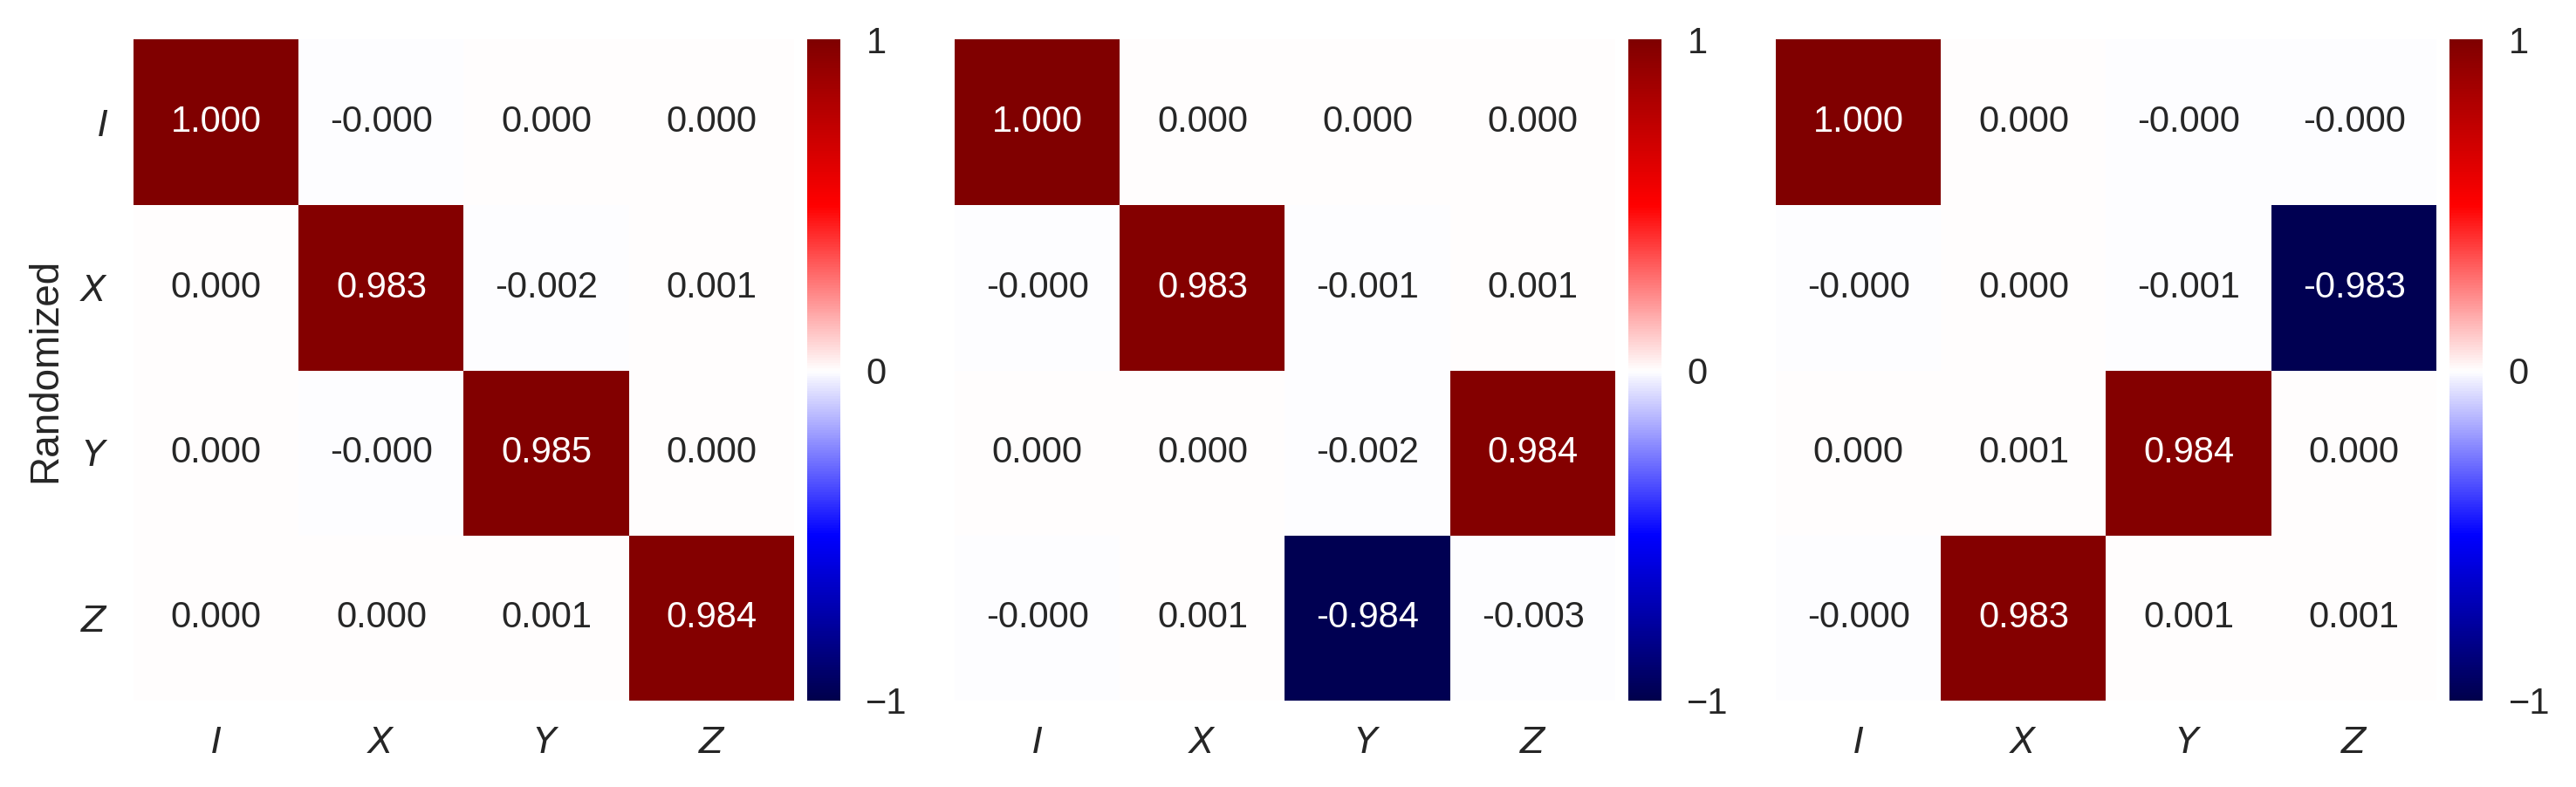

In [335]:
expr = 1
f,(ax1,ax2,ax3) = subplots(1,3, 
                           gridspec_kw=Dict("width_ratios"=>[1,1,1]),
                           figsize=(10,10))
ax = [ax1,ax2,ax3]
labels = [L"$\mathbb{I}$",L"$X_\frac{\pi}{2}$",L"$Y_\frac{\pi}{2}$"]

for g in 1:3
    divider = mplt[:make_axes_locatable](ax[g])
    cax = divider[:append_axes]("right", size="5%", pad=0.05)
    sca(ax[g])
    sns.heatmap(
        real.(rgst_gates[g,expr]|>liou2pauliliou),
        annot=true,
        square=true,
        fmt="3.3f",
        vmin=-1,
        vmax=1,
        cbar=true,
        ax=ax[g],
        cbar_ax=cax,
        annot_kws=Dict("size"=> 10),
        cbar_kws=Dict("ticks"=>[-1,0,1]),
        cmap="seismic")
    #title(latexstring(labels[g]," reconstruction"))
    if g==1 ylabel("Randomized") end
    tick_params("x", bottom=true, top=false, labelbottom=true, labeltop=false)
    if g==1
        tick_params("y", left=true, right=false, labelleft=true, labelright=false)
    else
        tick_params("y", left=false, right=false, labelleft=false, labelright=false)
    end
    ax[g][:set_xticklabels]([L"I",L"X",L"Y",L"Z"], rotation=0)
    ax[g][:set_yticklabels](reverse([L"I",L"X",L"Y",L"Z"]), rotation=0)
end
tight_layout()
savefig("../figs/full-reconstruction-rand.png", dpi=600)

#### without PFR

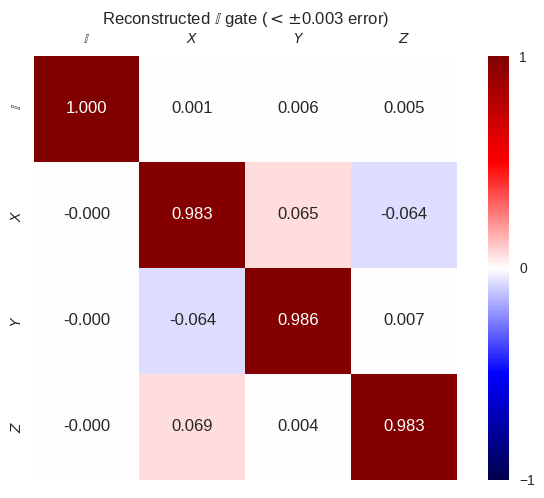

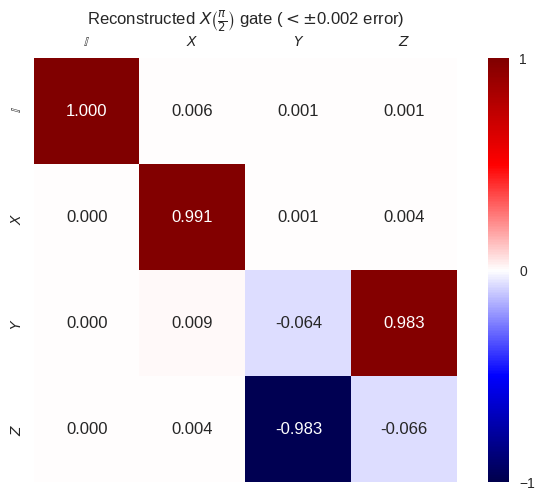

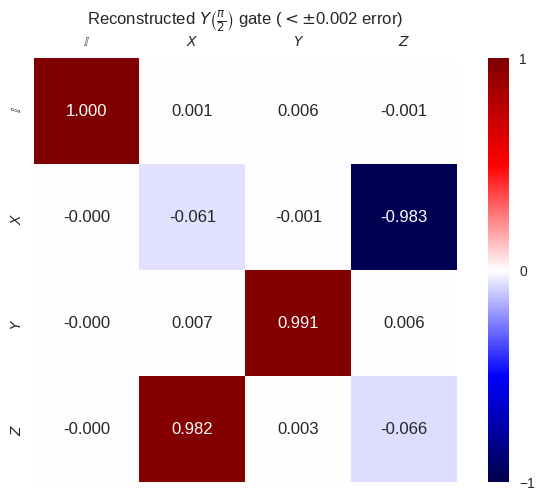

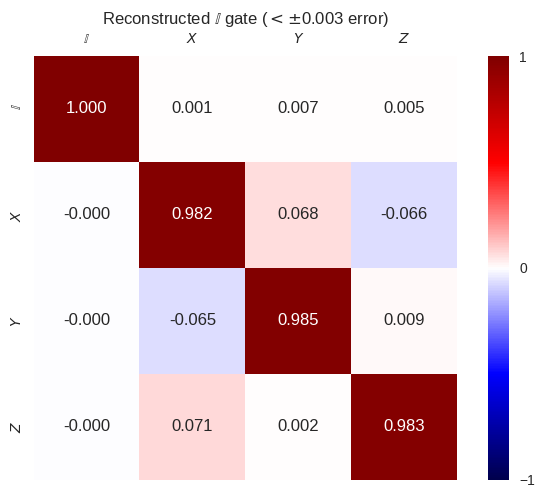

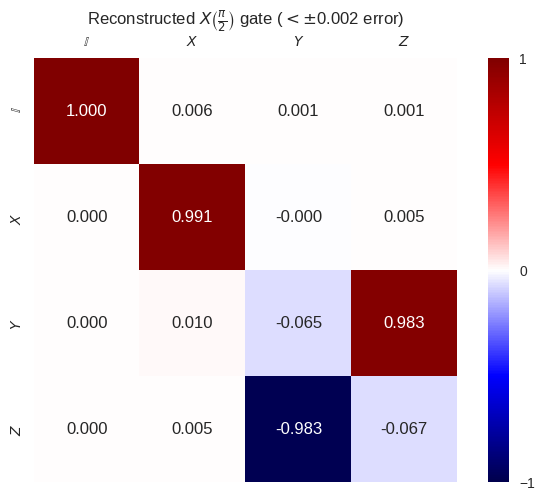

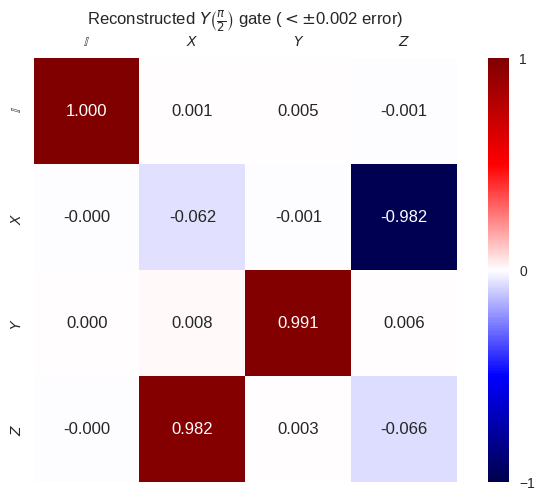

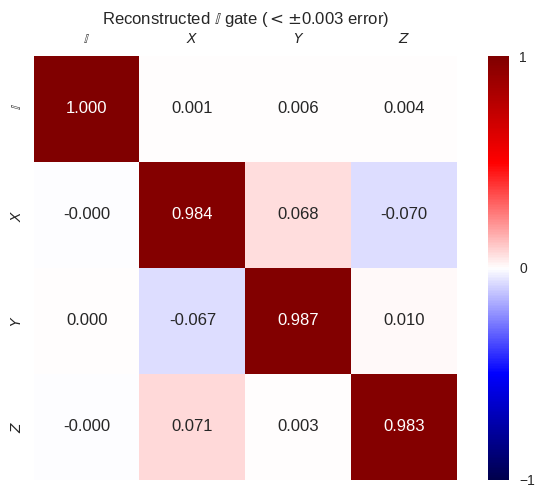

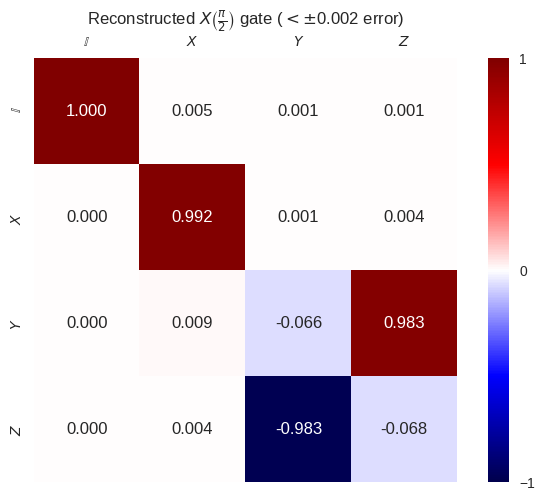

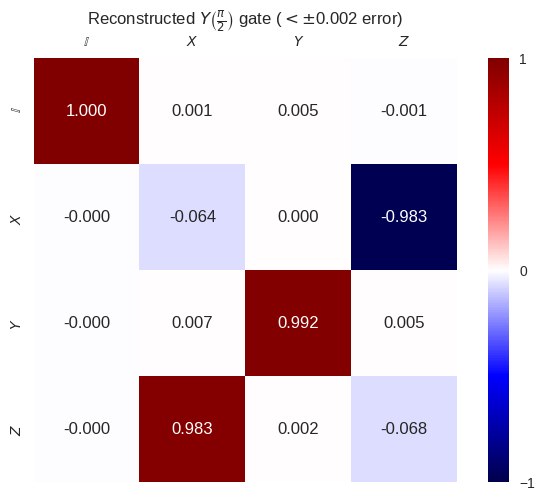

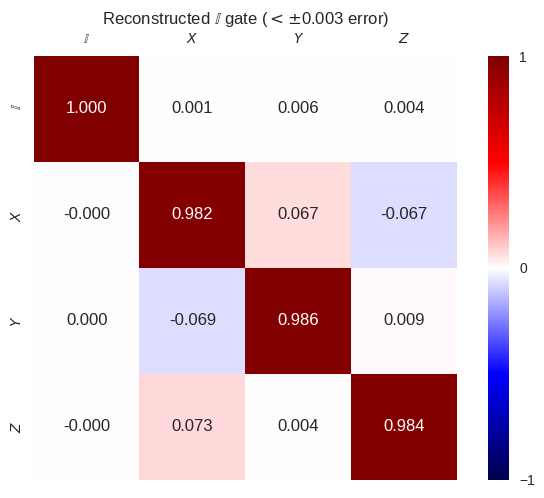

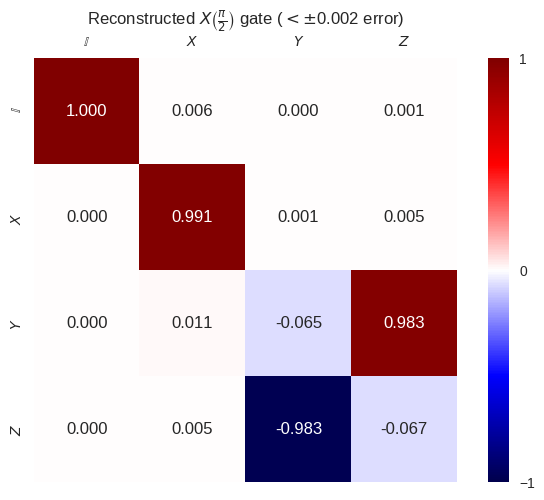

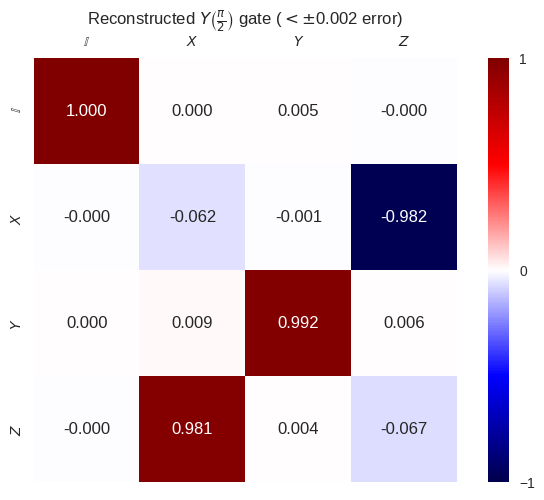

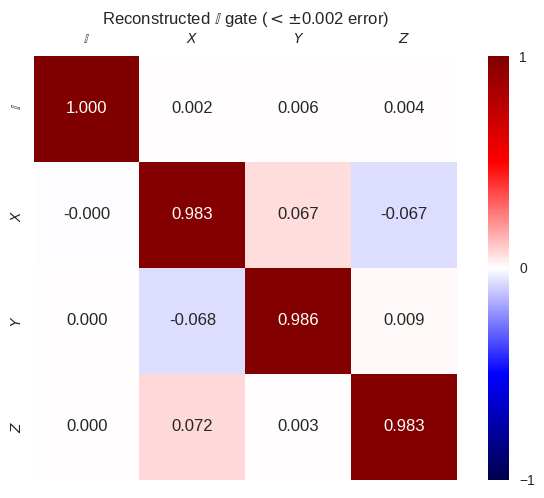

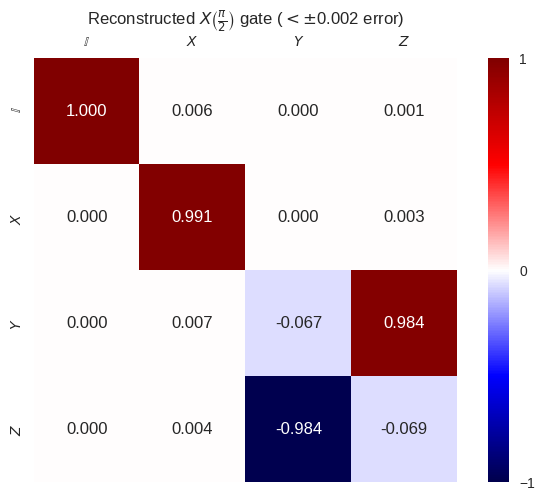

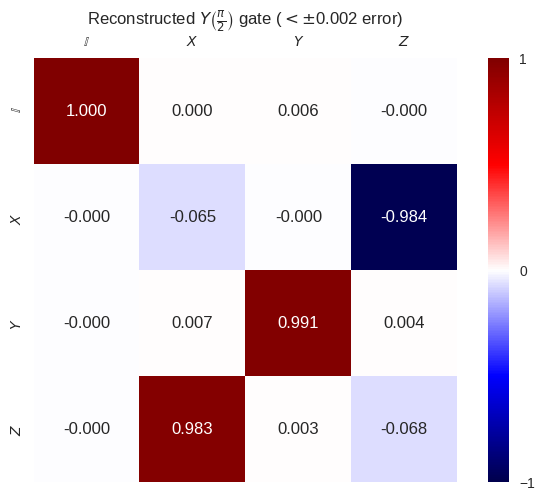

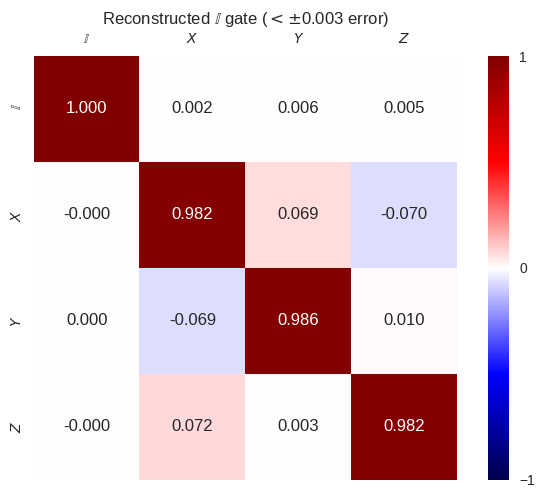

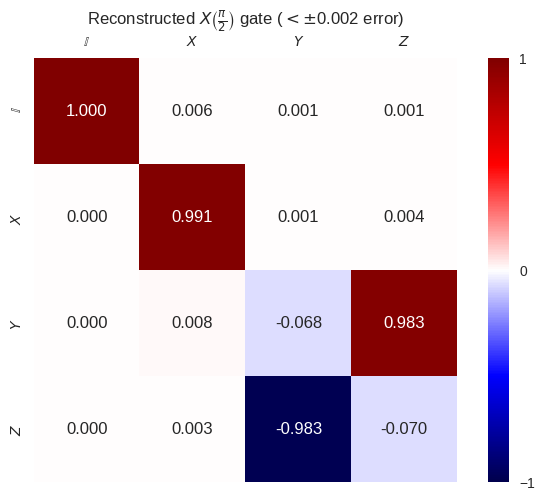

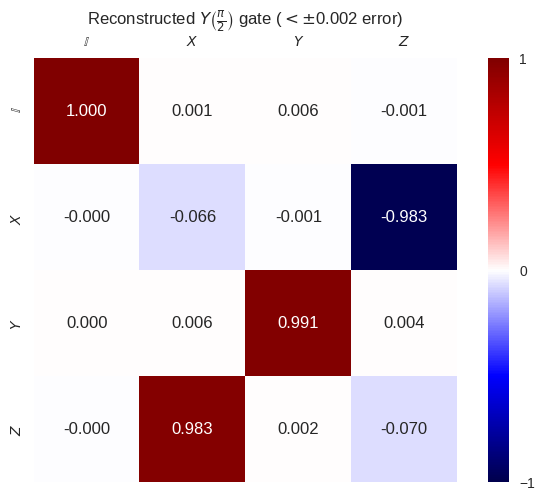

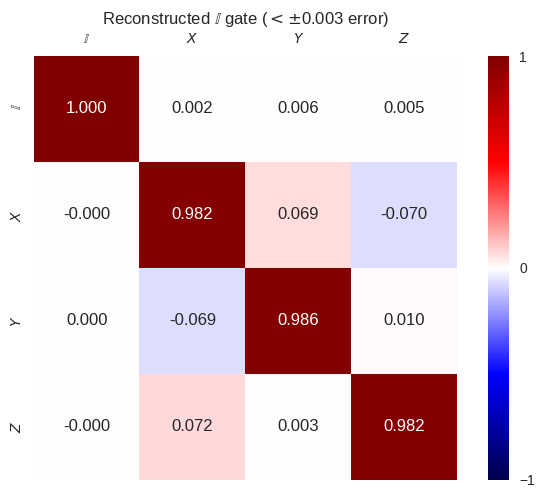

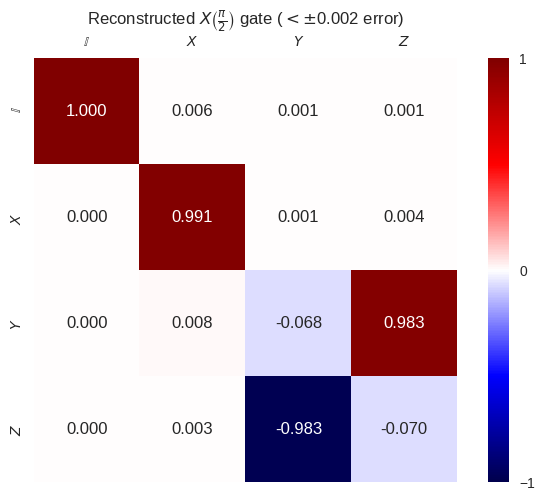

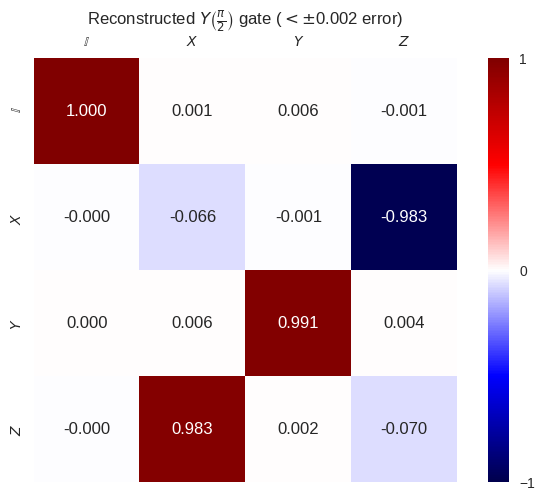

In [211]:
for expr in 1:7
    for g in 1:3
        figure()
        sns.heatmap(
            real.(gst_gates[g,expr]|>liou2pauliliou),
            annot=true,
            square=true,
            fmt="3.3f",
            vmin=-1,
            vmax=1,
            cmap="seismic",
            cbar_kws=Dict("ticks"=>[-1,0,1])
        )
        tick_params("x", bottom=false, top=true, labelbottom=false, labeltop=true)
        xticks(linspace(0.5,3.5,4),[L"\mathbb{I}",L"X",L"Y",L"Z"])
        yticks(linspace(0.5,3.5,4),reverse([L"\mathbb{I}",L"X",L"Y",L"Z"]));
        title(latexstring("Reconstructed ",gate[g],L" gate ($<\pm$", (@sprintf "%3.3f error)" gst_cis_max[g,expr])))
        savefig("../figs/mat-gst-gate-$g-expr-$expr.png",dpi=300)
    end
end

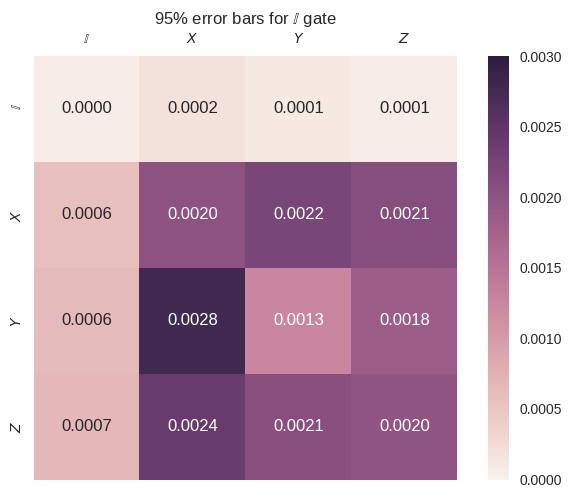

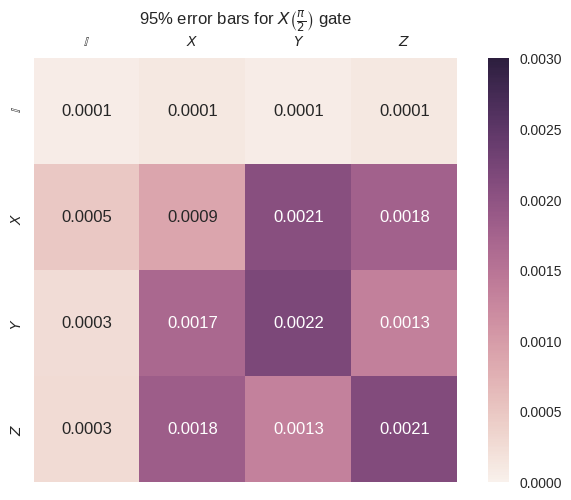

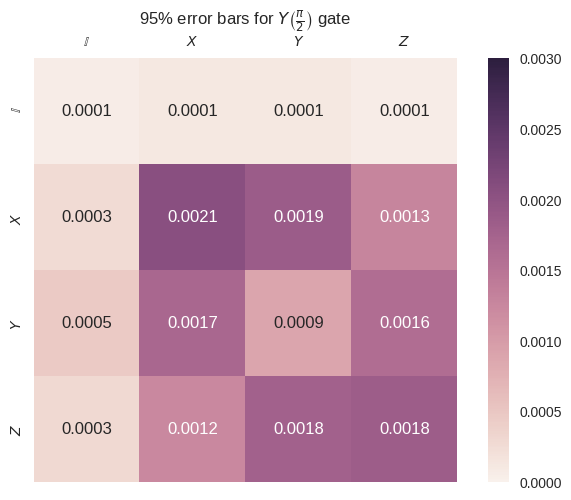

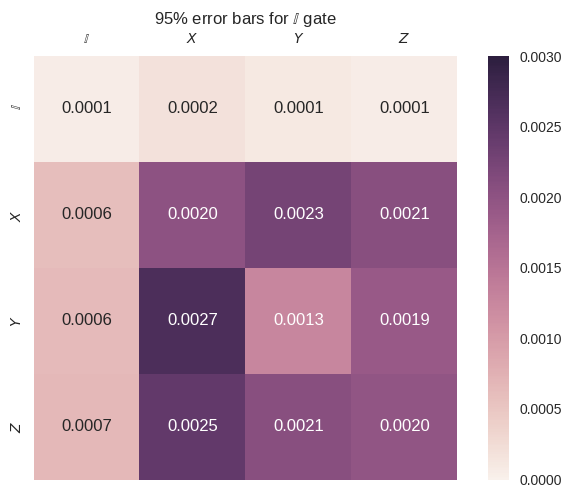

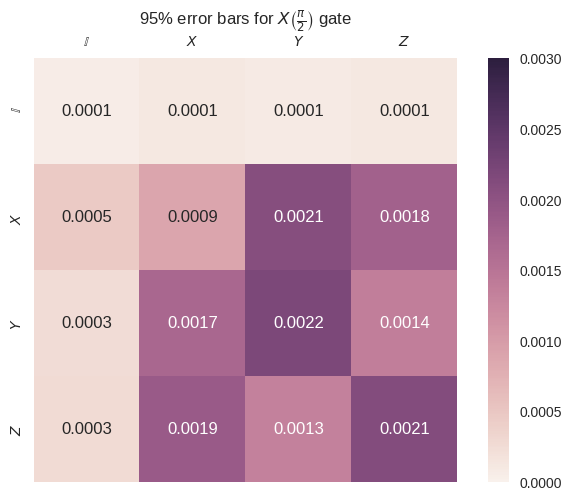

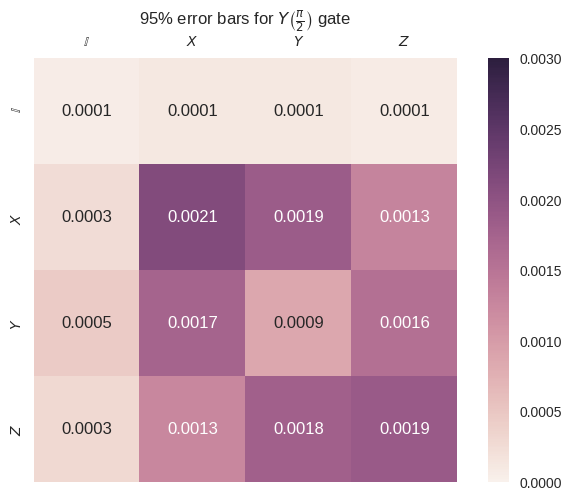

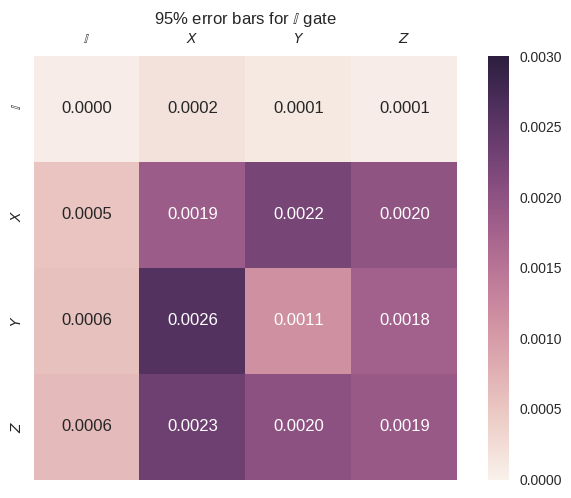

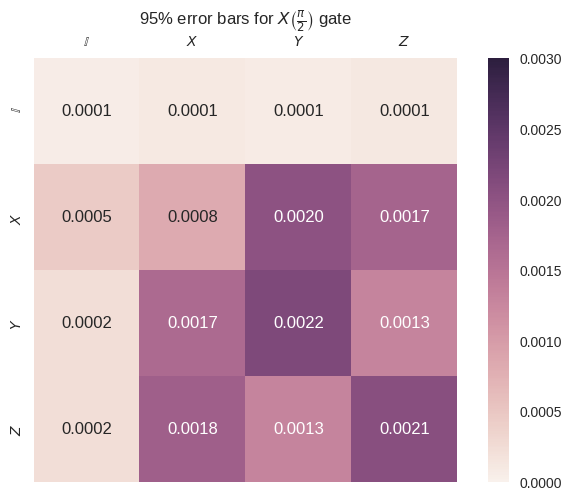

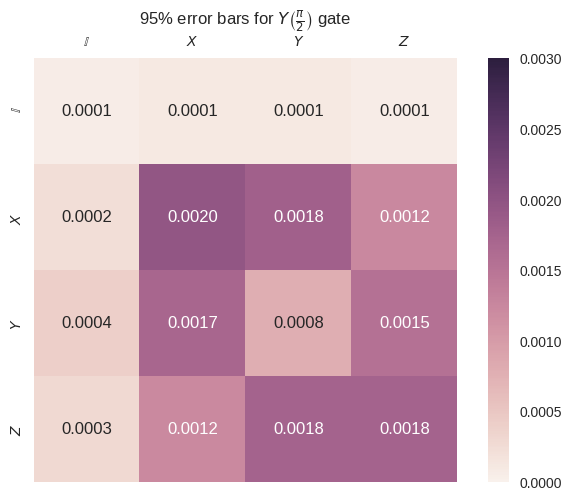

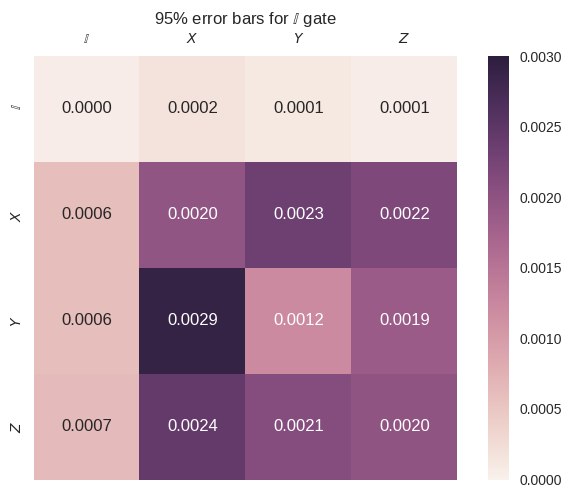

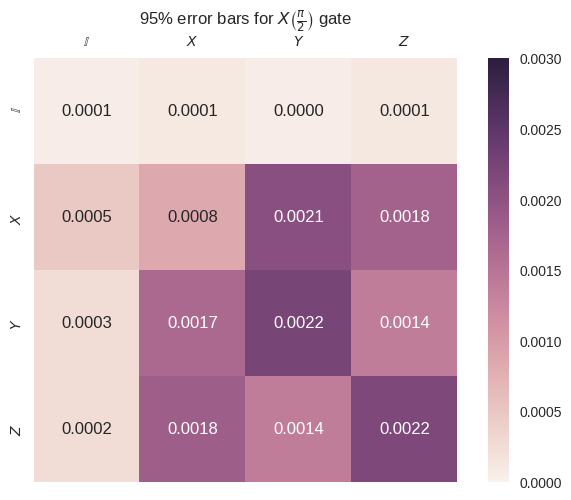

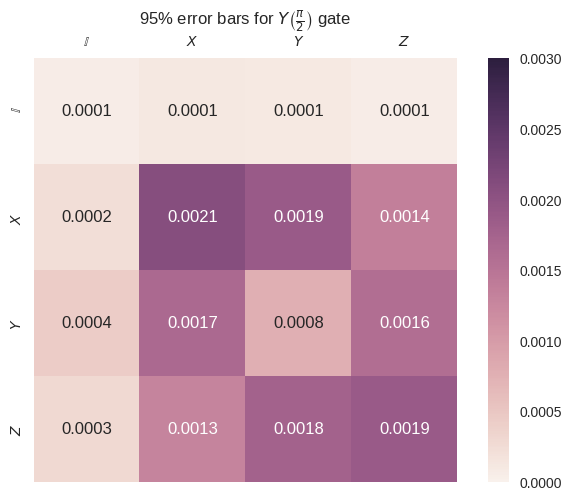

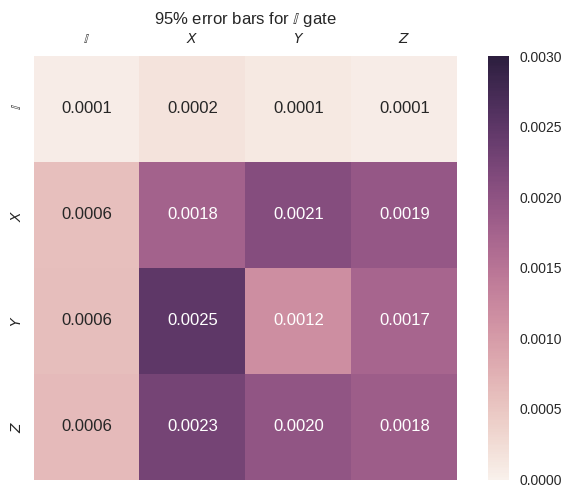

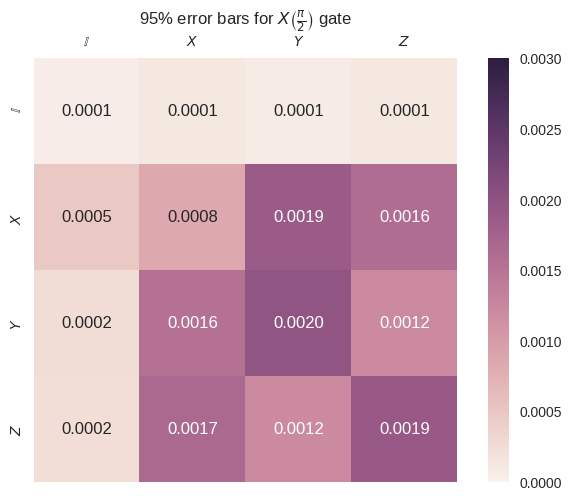

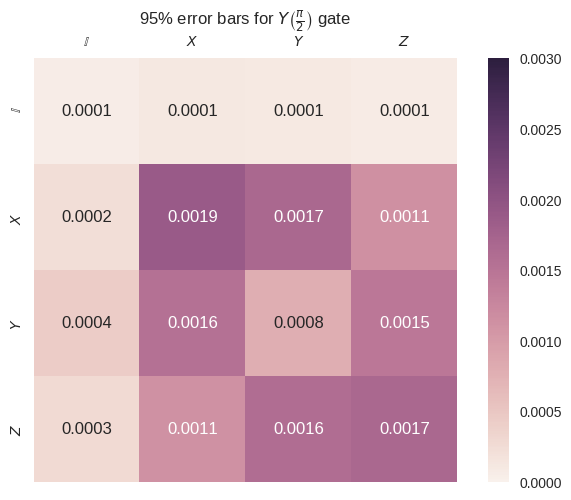

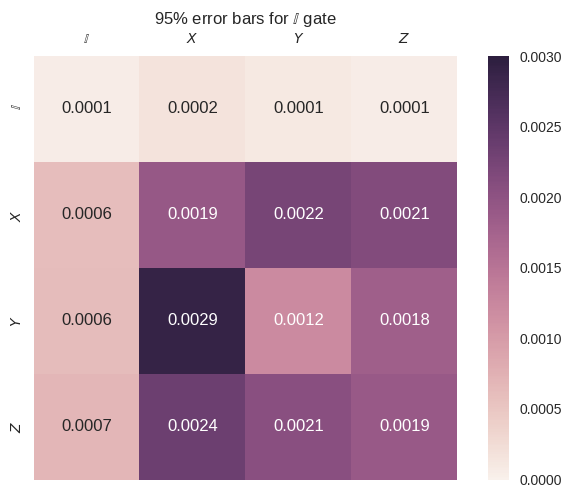

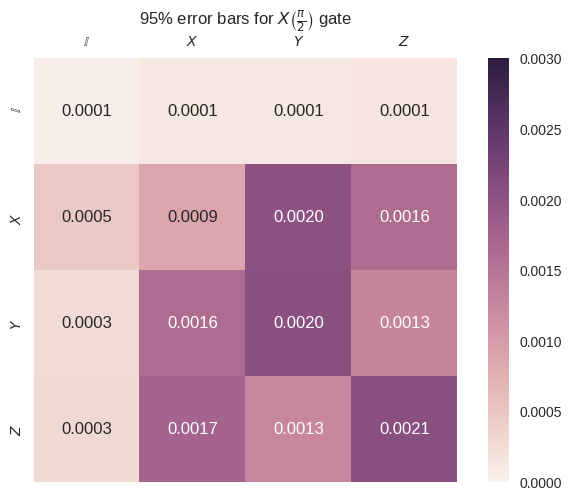

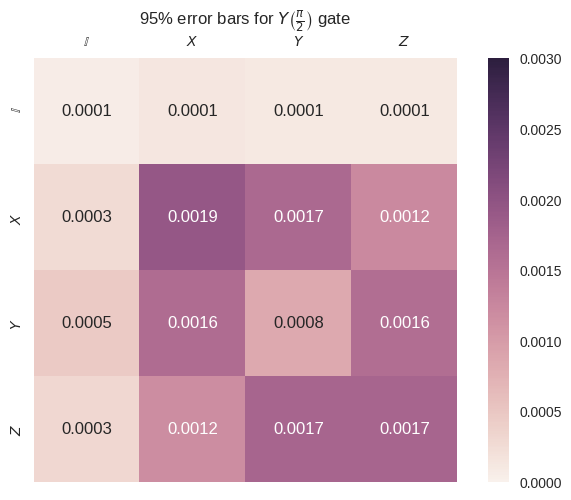

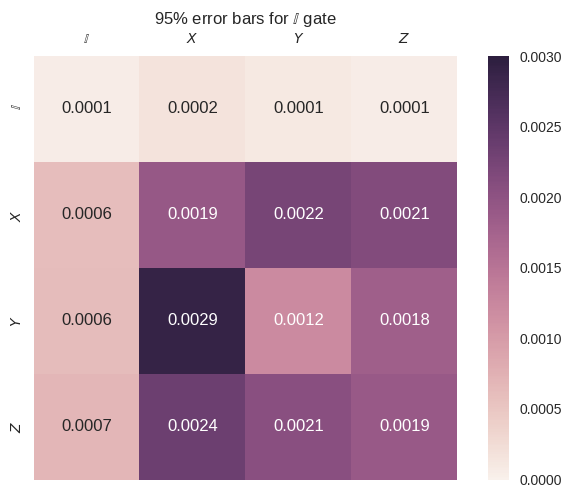

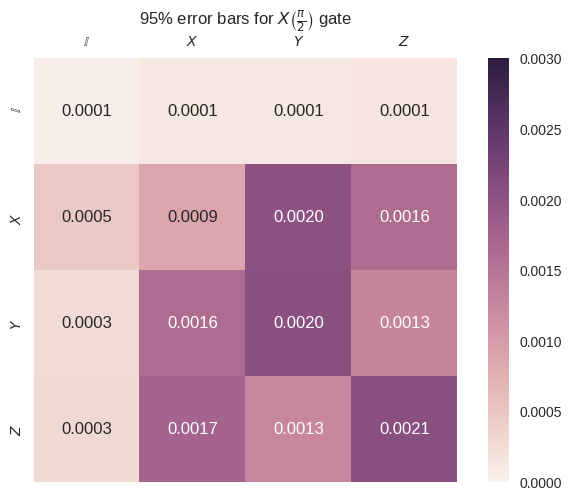

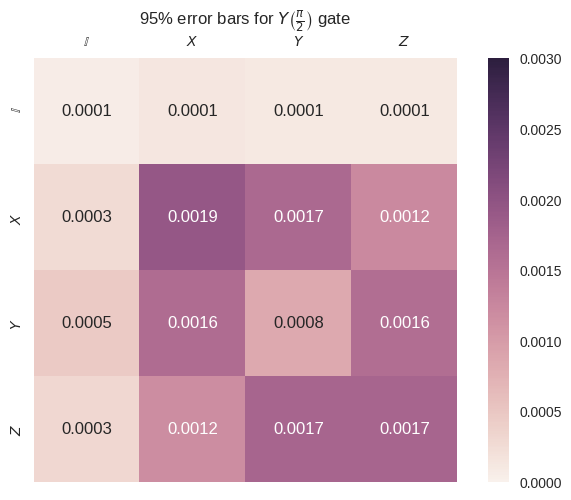

In [212]:
for expr in 1:7
    for g in 1:3
        figure()
        sns.heatmap(
            real.(gst_cis[g,expr]),
            annot=true,
            square=true,
            fmt="3.4f",
            vmin=0,
            vmax=emax)
        tick_params("x", bottom=false, top=true, labelbottom=false, labeltop=true)
        xticks(linspace(0.5,3.5,4),[L"\mathbb{I}",L"X",L"Y",L"Z"])
        yticks(linspace(0.5,3.5,4),reverse([L"\mathbb{I}",L"X",L"Y",L"Z"]));
        title(latexstring("95% error bars for ",gate[g]," gate "))
        savefig("../figs/errbar-gst-gate-$g-expr-$expr.png",dpi=300)
    end
end

#### with PFR

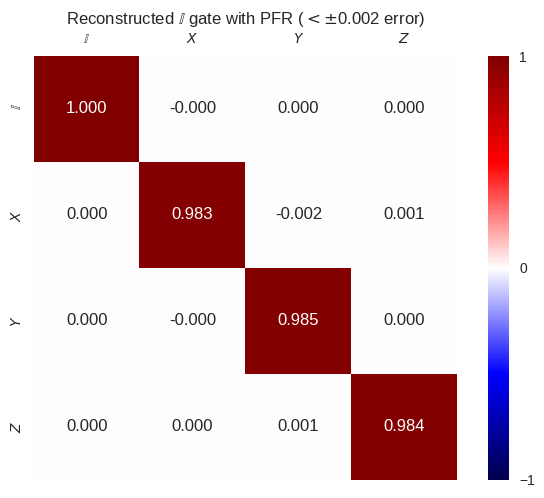

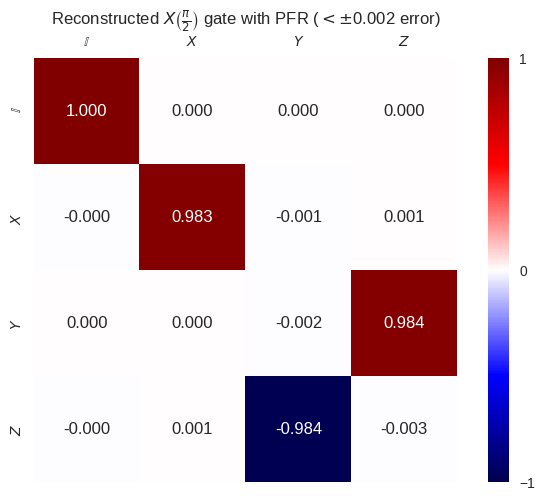

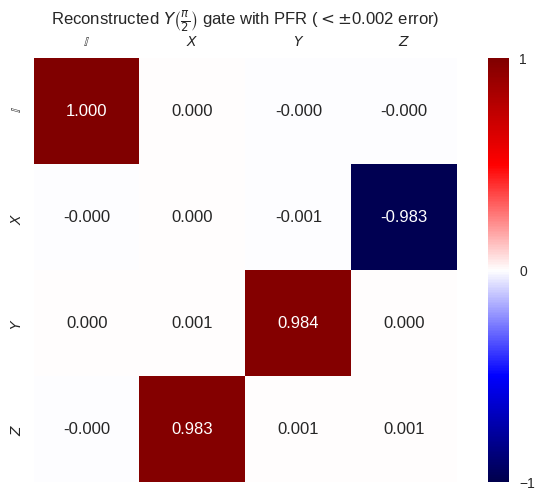

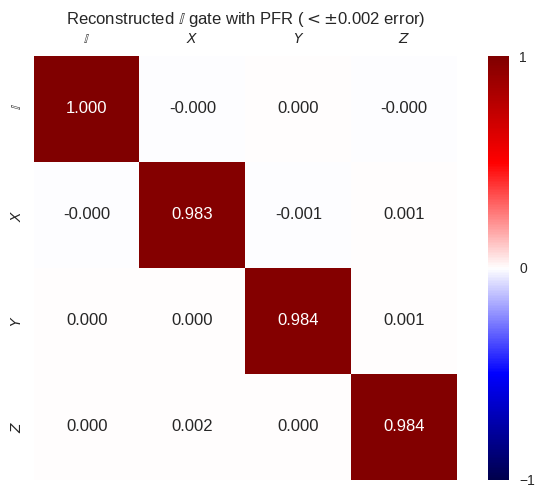

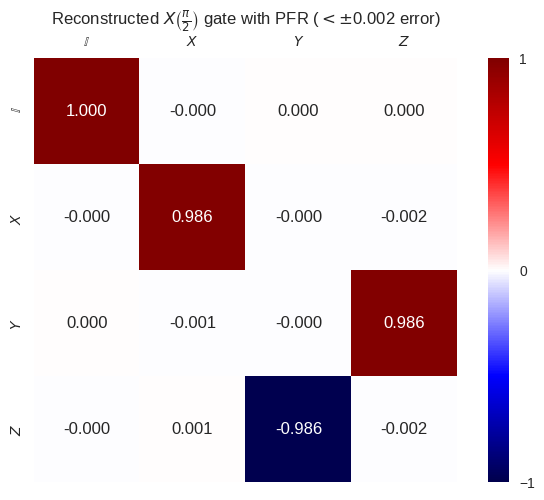

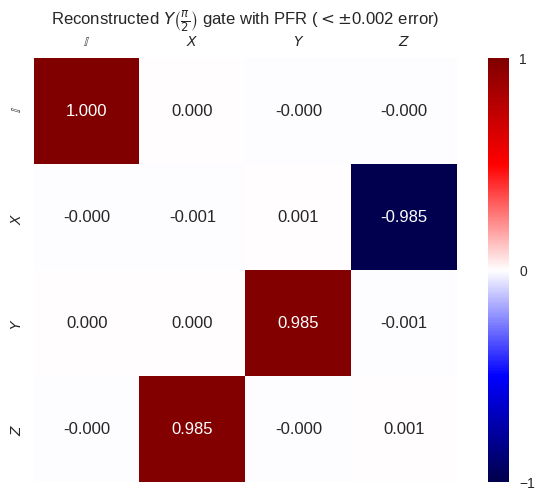

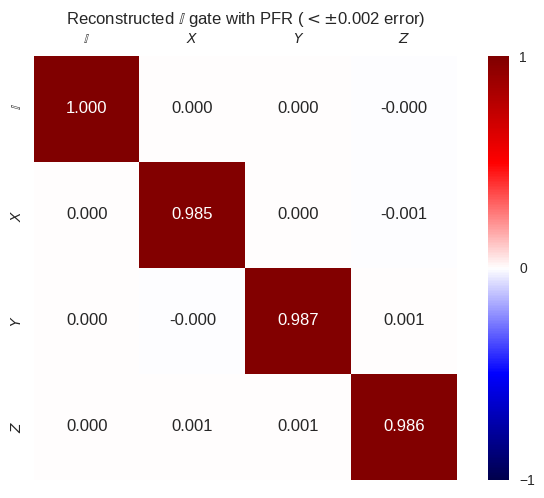

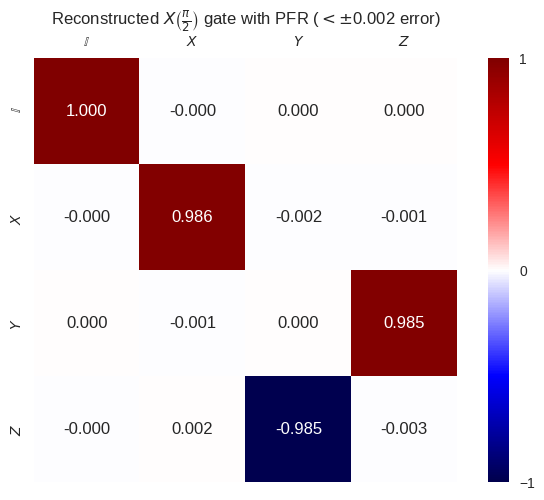

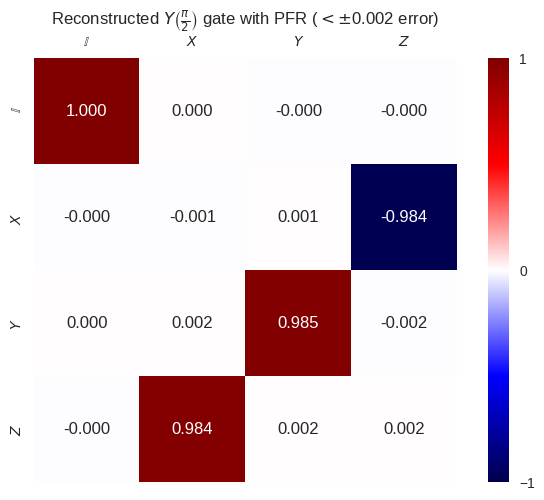

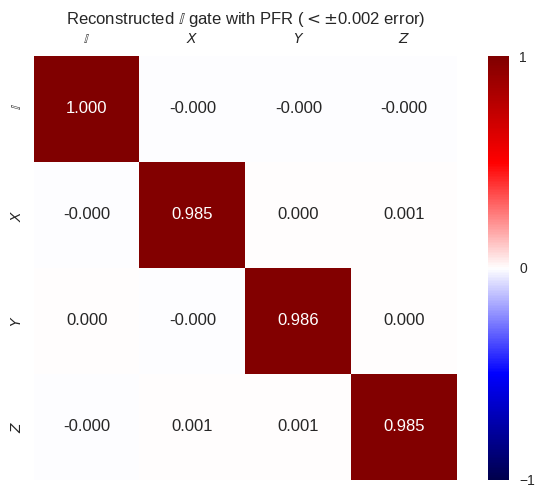

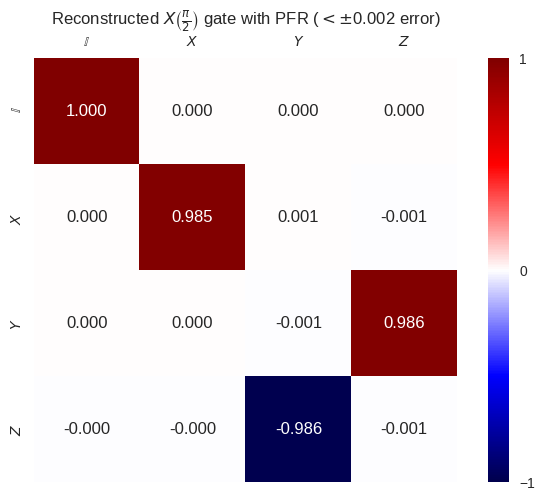

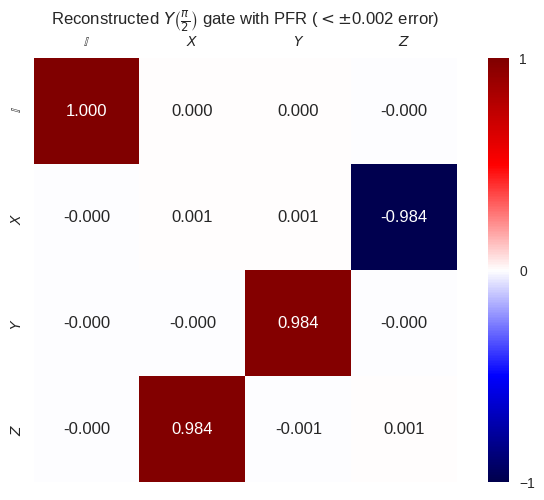

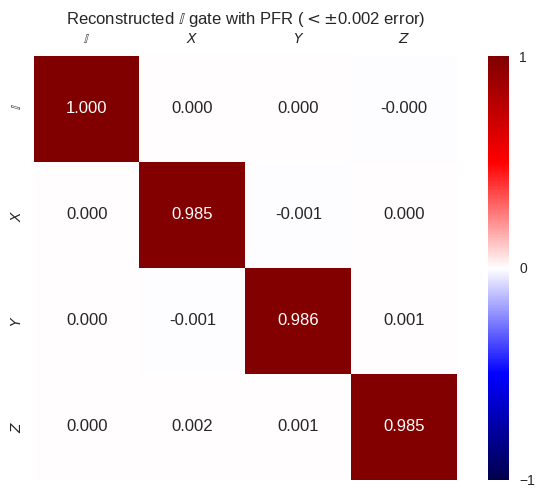

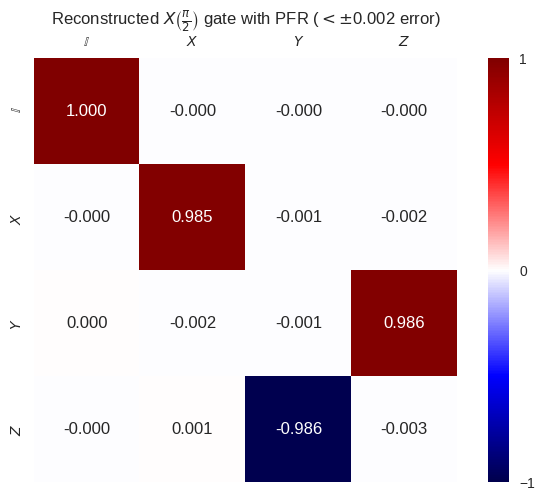

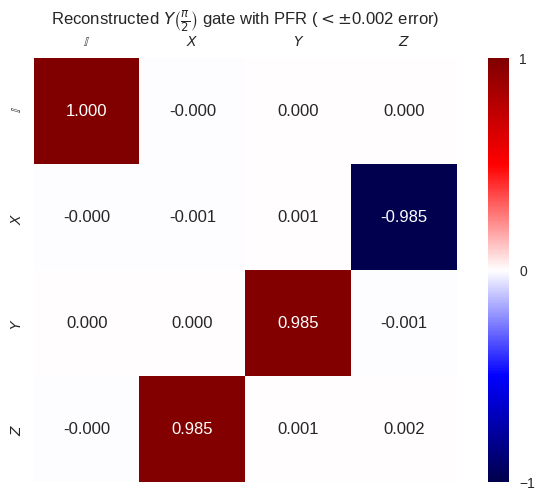

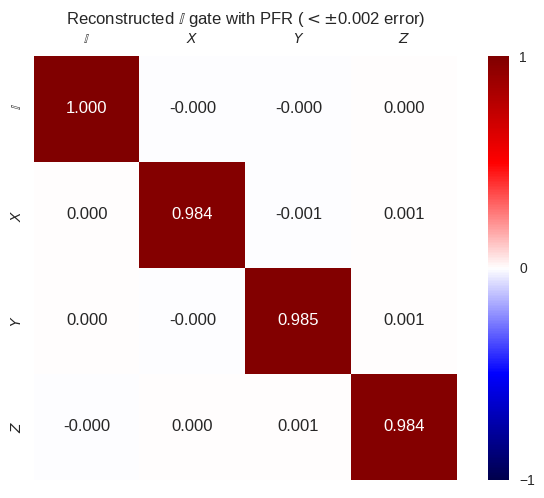

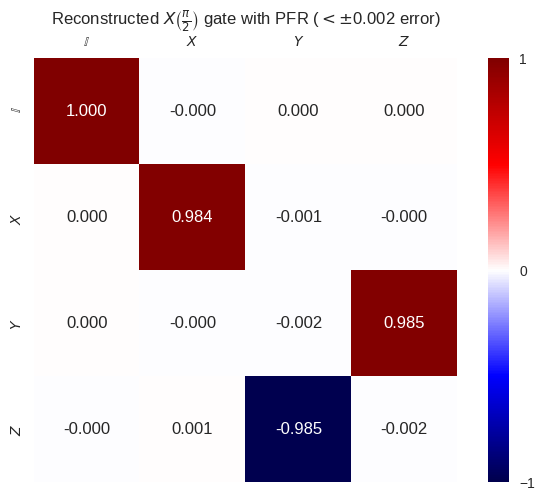

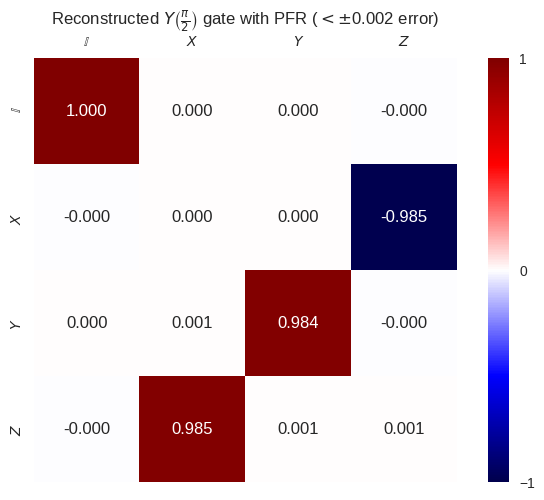

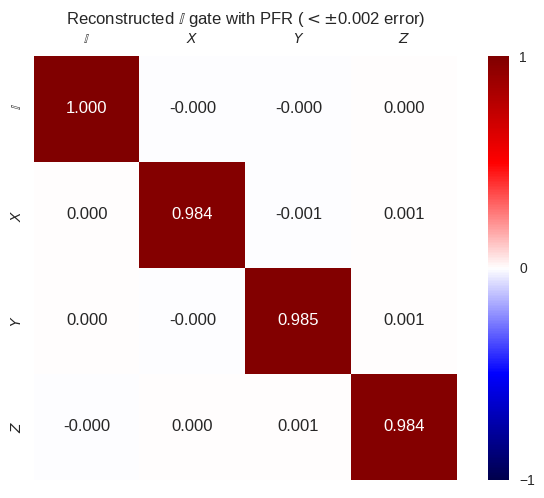

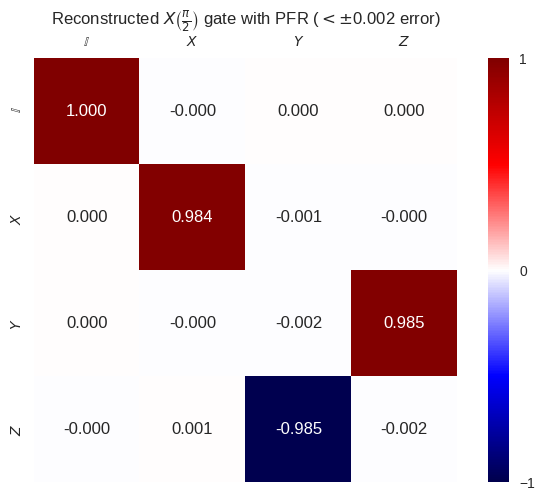

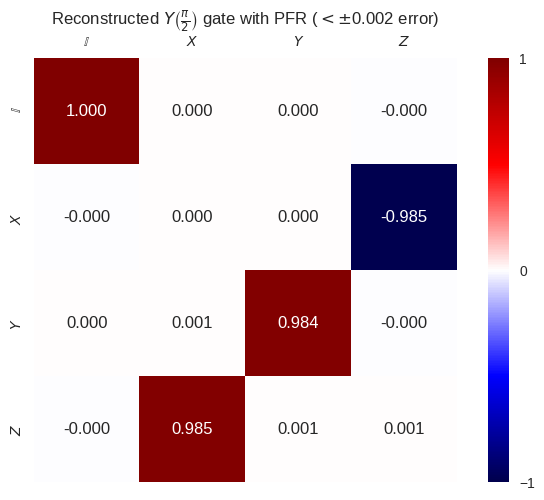

In [213]:
for expr in 1:7
    for g in 1:3
        figure()
        sns.heatmap(
            real.(rgst_gates[g,expr]|>liou2pauliliou),
            annot=true,
            square=true,
            fmt="3.3f",
            vmin=-1,
            vmax=1,
            cmap="seismic",
            cbar_kws=Dict("ticks"=>[-1,0,1]))
        tick_params("x", bottom=false, top=true, labelbottom=false, labeltop=true)
        xticks(linspace(0.5,3.5,4),[L"\mathbb{I}",L"X",L"Y",L"Z"])
        yticks(linspace(0.5,3.5,4),reverse([L"\mathbb{I}",L"X",L"Y",L"Z"]));
        title(latexstring("Reconstructed ",gate[g],L" gate with PFR ($<\pm$", (@sprintf "%3.3f error)" rgst_cis_max[g,expr])))
        savefig("../figs/mat-rgst-gate-$g-expr-$expr.png",dpi=300)
    end
end

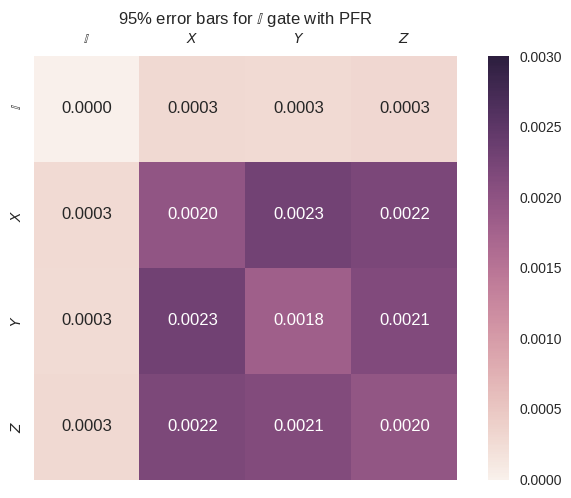

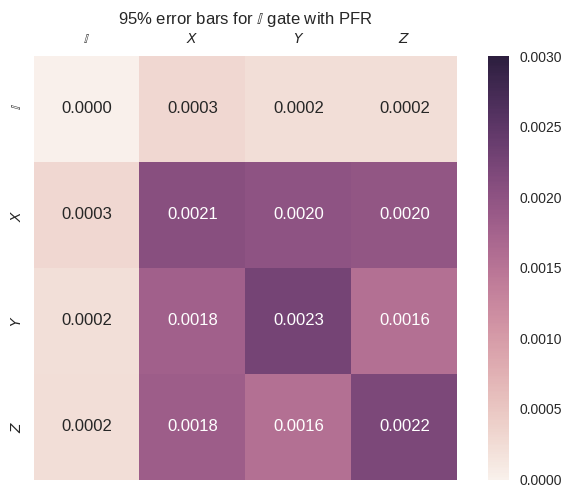

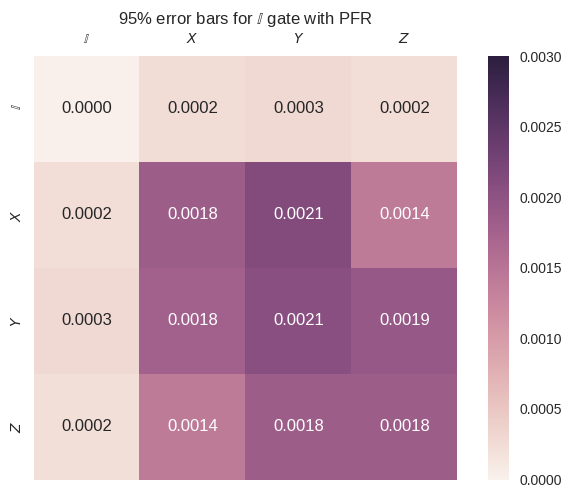

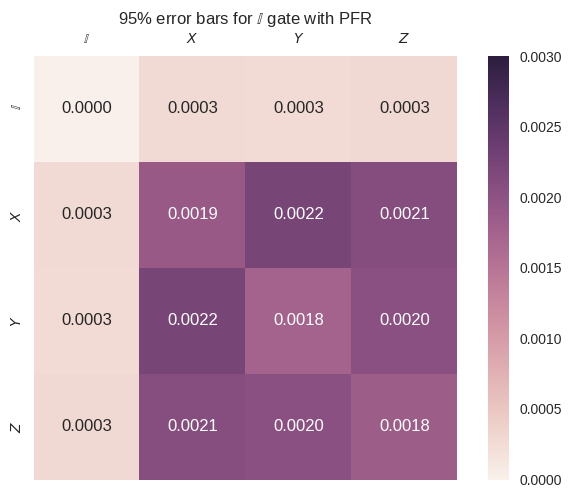

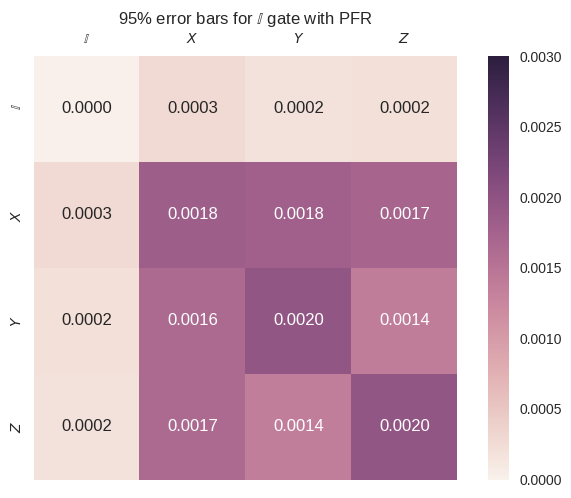

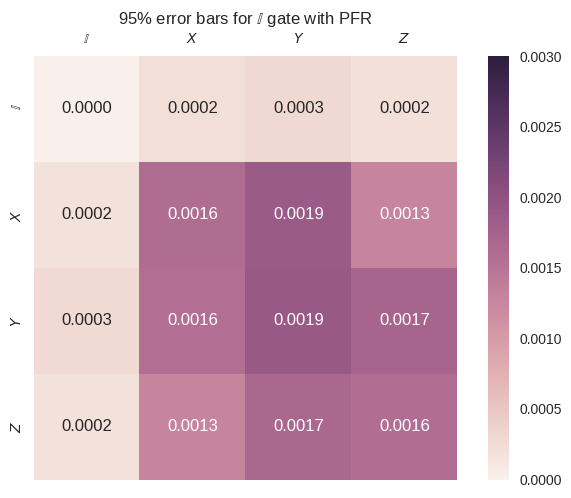

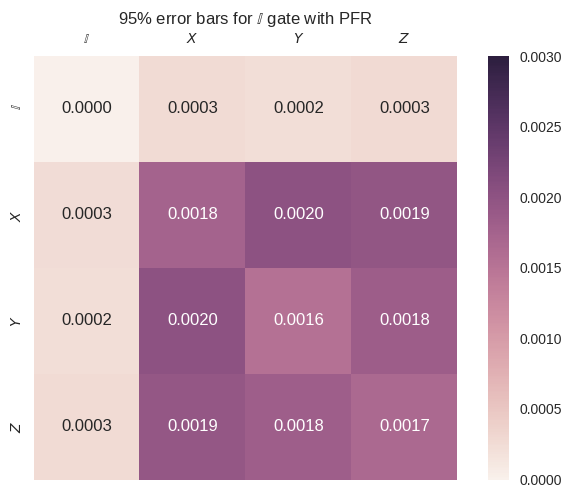

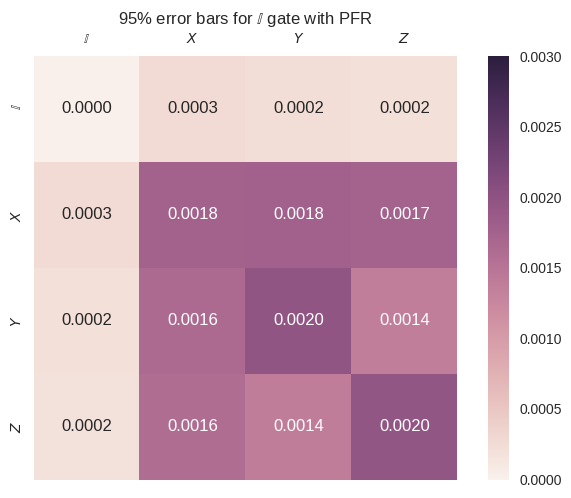

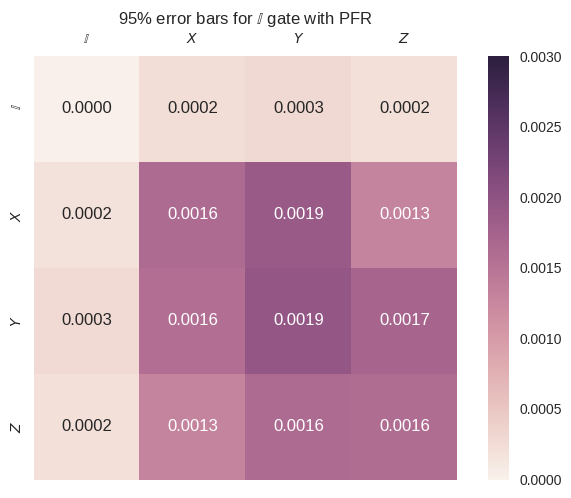

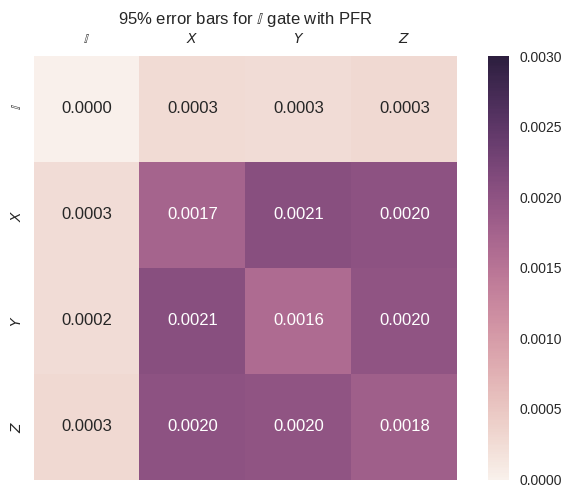

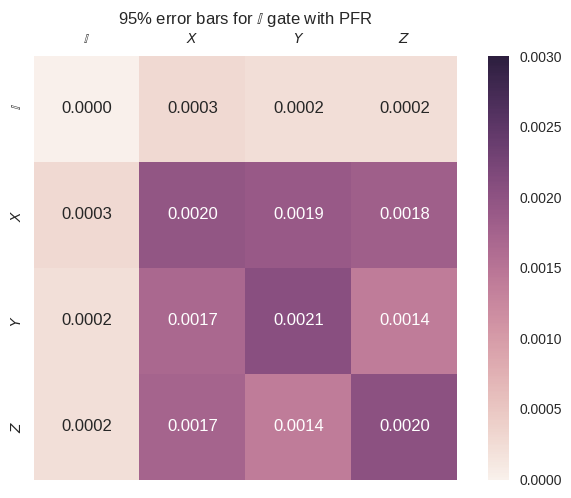

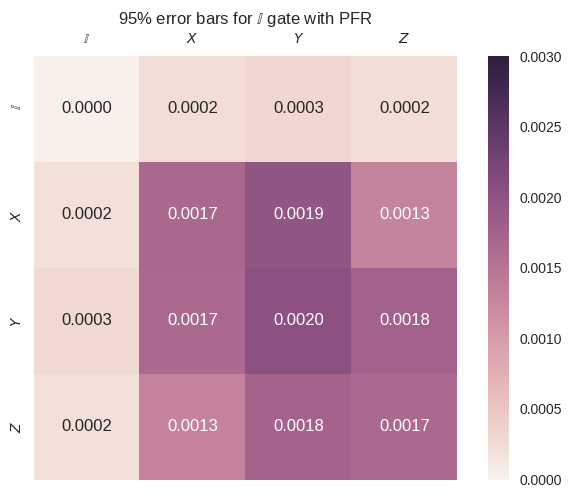

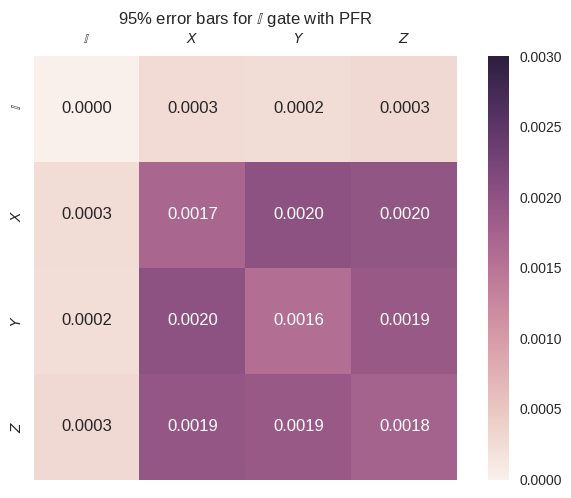

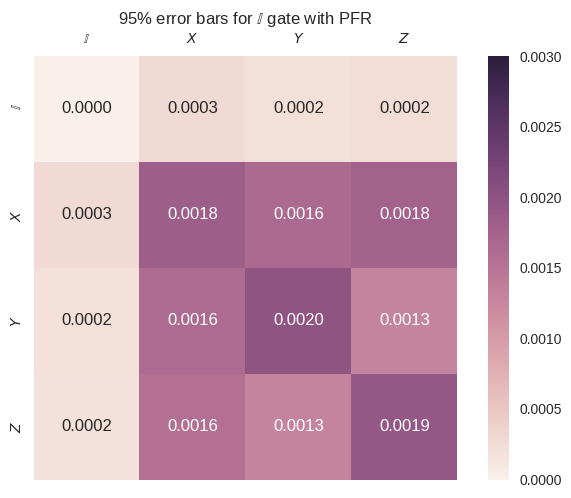

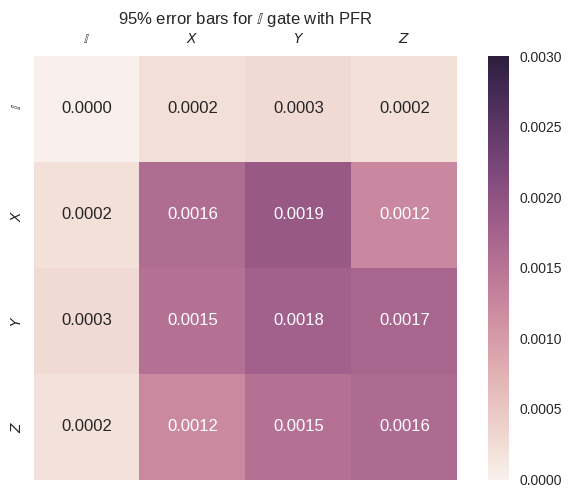

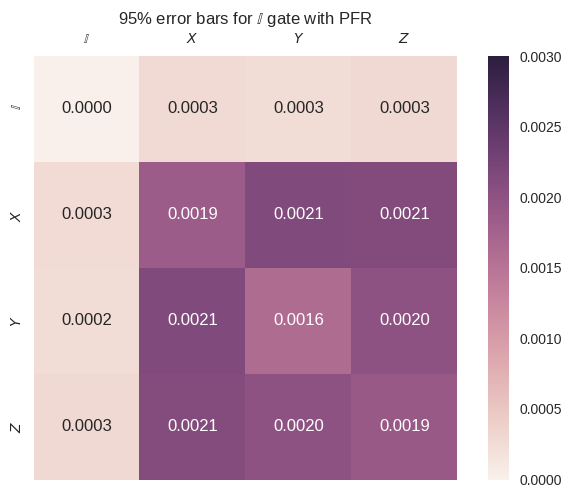

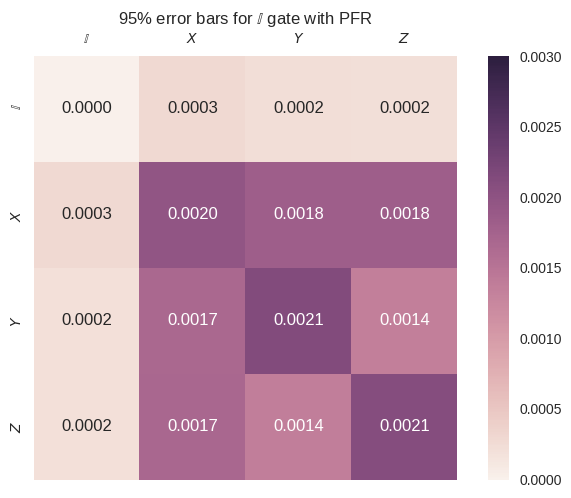

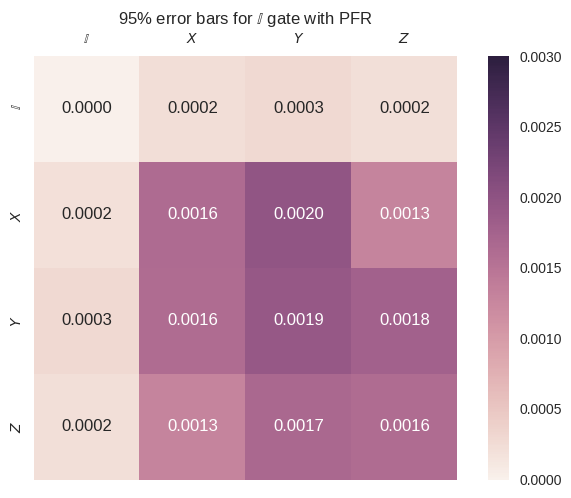

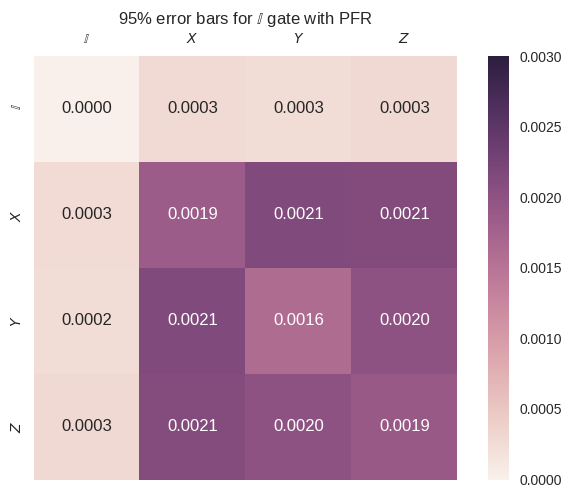

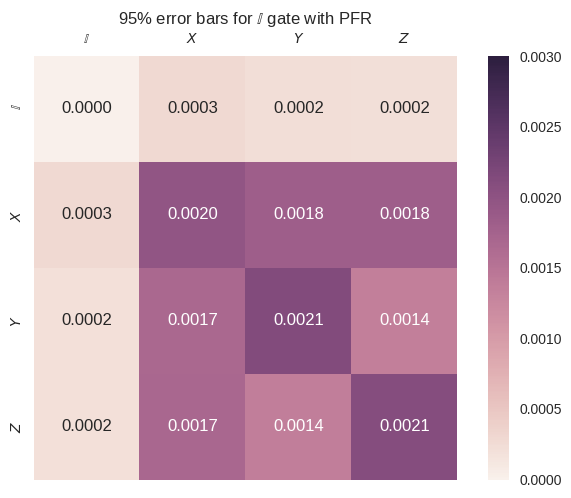

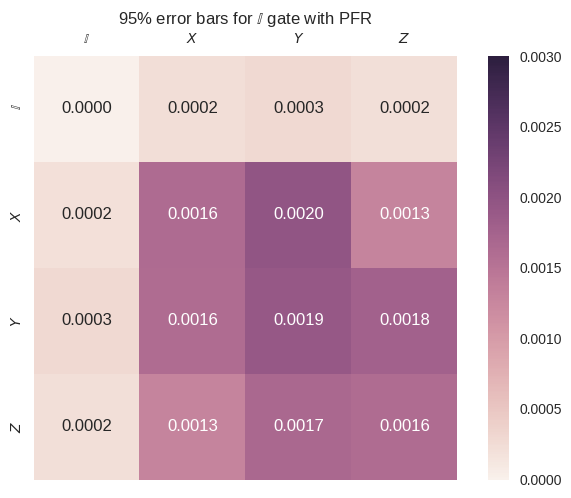

In [307]:
for expr in 1:7
    for g in 1:3
        figure()
        sns.heatmap(
            real.(rgst_cis[g,expr]),
            annot=true,
            square=true,
            fmt="3.4f",
            vmin=0,
            vmax=emax)
        tick_params("x", bottom=false, top=true, labelbottom=false, labeltop=true)
        xticks(linspace(0.5,3.5,4),[L"\mathbb{I}",L"X",L"Y",L"Z"])
        yticks(linspace(0.5,3.5,4),reverse([L"\mathbb{I}",L"X",L"Y",L"Z"]));
        title(latexstring("95% error bars for ",gate[1]," gate with PFR"))
        savefig("../figs/errbar-rgst-gate-$g-expr-$expr.png",dpi=300)
    end
end

In [315]:
[maximum(real.(gst_cis[g,1])) for g in 1:3]

3-element Array{Float64,1}:
 0.00277356
 0.00219104
 0.00205099

In [312]:
[maximum(real.(rgst_cis[g,1])) for g in 1:3]

3-element Array{Float64,1}:
 0.00230257
 0.00226219
 0.00213522